# Text Analysis in Python 4: Topics & Emotions

<h1 style="text-align:center;font-size:300%;">The State of the Union is... scared??</h1> 
  <img src="https://api.time.com/wp-content/uploads/2016/07/emoticons.jpg?quality=85&w=600" style="width:%80;">
  <!--<img src="http://www.languagetrainers.com/blog/wp-content/uploads/2012/10/us-are-vs-us-is1.png" style="width:%140;">-->



## Topic Modeling, Sentiment Analysis, and other Inductive Approaches to Text Analysis

To what extent can text analysis approaches identify topics, emotions, and other aspects of texts without any prior input by the researcher?

In this session, participants will:
+ learn what sentiment analysis and topic modeling can and can't do
+ modify and interpret a series of sentiment analysis graphs
+ briefly experiment with topic modeling while examining its limits

<!--
*Explain Topic Modeling / Give Examples Of (both good and bad)
Present Buckets of Words Examples and have students interpret
Apply Topic Modeling to SOTU Texts (does it make sense to do so? it certainly would be interesting to see which SOTU addresses are lumped in with which others)
Compare to out-of-the-box approaches (Voyant, etc.)*-->

<div class="alert alert-success" role="alert"><h3 style="color:green">Code Together:</h3><p style="color:green">In these cell blocks, we will code together. You can find the completed version in our shared folder (ending with "_completed.ipynb").</p></div>

<div class="alert alert-info" role="alert"><h3 style="color:blue;">Exercises:</h3><p style="color:blue">are in blue text. These are a chance to practice what you have learned.</p></div>

<div style = "background-color:#f3e5f5"><h3 style="color:purple">Python Basics - Additional Practice</h3><p style="color:purple">are in purple text. Work on these after the lesson if you would like more practice.</p></div>

## Further Practice

For further practice, we recommend you review the sections on [Sentiment Analysis](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/04-Sentiment-Analysis.html) and [Topic Modeling](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/05-Topic-Modeling.html) in Ch. 5 in Melanie Walsh's *Introduction to Cultural Analytics*. You can even practice with this code yourself by pressing the Rocket Ship icon at the top of each section and opening a [**Binder**](https://mybinder.org/) session which will allow you to run code in her Jupyter Notebooks.

## Part I: Setup

1. First, let's import all required libraries/packages.

In [1]:
import pathlib, os             #for navigating through files and working with file paths
from pathlib import Path
import nltk                    #Natural Language Toolkit - large package for text analysis and natural language processing
import spacy                   # more NLP
nlp = spacy.load("en_core_web_sm")

import re                      #re = regular expressions - a tool for searching for patterns in texts (i.e. remove all punctuation; identify all words that begin with a capitalized letter; identify phone numbers by searching for the pattern ###-###-####) 
import collections
import gensim                  # for topic modeling 
import pandas as pd            #for working with dataframes
import numpy as np             # for working with arrays of numbers (single dimension: array; 2d: matrix; 3+d: tensor)
import matplotlib              #these 2 lines of code: importing Python libraries for visualization
import matplotlib.pyplot as plt, seaborn as sns

from ast import literal_eval

nltk.download('punkt')         #nltk - here we need to download and import specific packages from nltk
from nltk import word_tokenize
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer

from nltk.stem import WordNetLemmatizer
nltk_lemmatizer = WordNetLemmatizer()


# from tqdm import tqdm_notebook as tqdm
#from tqdm import notebook as tqdm   #for creating a progress bar to show computation in progress
#from tqdm import trange

plt.style.use('fivethirtyeight')    # sets the style for our plots, other style options here: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
#%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]  #sets size of the visualizations in our notebook
#%config InteractiveShellApp.matplotlib = 'inline'
#%config InlineBackend.figure_formats = ['svg']




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\F0040RP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2. ... and then open our dataframe with the fulltext and tokenized lists for each SOTU address. 

In [2]:
sotudf = pd.read_csv("sotudf.tsv", encoding = "utf-8", sep = "\t", index_col = 0, 
                     converters = {'tokens': literal_eval, 'ltoks': literal_eval, 'ltoks_ns': literal_eval})
#converters needed otherwise pandas reads in a list of tokens [gentlemen, of, the, ...] and surrounds each word with quotation marks
## like ['gentlemen', 'of', 'the', ...] which creates all kinds of problems
sotudf.head(3)

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   

                                            ltoks_ns  
0  [gentlemen, senate, gentlemen, house, represen...  
1  [gentlemen, senate, gentlemen, house, represen...  
2  [gentlemen, senate, gentlemen, house, represen...

3. As you may recall, there is one empty text file in our dataset. Since Washington did not give a SOTU address in 1790, the person who compiled this SOTU corpus created an empty text file for 1790 to indicate that the 1790 address was not forgotten, but simply was never given.

For our sentiment analysis, however, we want to remove all null data (in this case the 1790 dummy file). We can do that using the **.notnull() function. When subsetting a dataframe, a simple way to see how it changed is to compare the dimensions of the dataframe (number of rows and columns) before and after applying the subset.

In [3]:
print(sotudf.shape)
sotudf = sotudf[sotudf['fulltext'].notnull()]
print(sotudf.shape)  #after removing empty 1790 row

(233, 7)
(232, 7)


<div class="alert alert-success" role="alert">
<h3  style="color:green">Code Together</h3>

<p style="color:green"> 4. Using the <a href = "https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf">Python Pandas Cheat Sheet (click here)</a>, inspect our SOTU dataframe ("sotudf") retrieving the number of rows and columns and the types of data stored in each column.</p>

</div>

In [4]:
print(sotudf.shape)
print(sotudf.info())

(232, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 232
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      232 non-null    int64 
 1   pres      232 non-null    object
 2   numtoks   232 non-null    int64 
 3   tokens    232 non-null    object
 4   fulltext  232 non-null    object
 5   ltoks     232 non-null    object
 6   ltoks_ns  232 non-null    object
dtypes: int64(2), object(5)
memory usage: 14.5+ KB
None


<div class="alert alert-success" role="alert">

<p style="color:green"> 5. Using the <a href = "https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf">Python Pandas Cheat Sheet (click here)</a>, can you identify if all lists of tokens are unique? (If they aren't then that indicates we made an error in compiling the dataset.)</p>

</div>

In [5]:
sotudf['numtoks'].nunique()

231

In [6]:
any(sotudf['ltoks'].duplicated())

False

<div class="alert alert-success" role="alert">
<p style="color:green"> 6. Next, we will create two new columns:
<ol style="color:green">
    <li>one that calculates the number of characters (rather than words) for each SOTU address</li>
    <li>another that calculates the average word-length of each address</li>
</ol>
<p style="color:green"><i>To do this, we can call an anonymous function using <b>lambda</b> within the <b>.apply()</b> method. There are other ways that are faster</p>
</div>

In [7]:
sotudf['num_chars'] = sotudf['fulltext'].apply(lambda x: len(x))   #.map() instead of .apply() works just as well
sotudf.head()

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
3  1800  Adams     1374  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
4  1825  Adams     9091  [Fellow, Citizens, of, the, Senate, and, of, t...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   
3  Gentlemen of the Senate and Gentlemen of the H...   
4  Fellow Citizens of the Senate and of the House...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   
3  [gentlemen, of, the, senate, and, gentlemen, o...   
4  [fellow, citizens, of, the, senate, and, of, t...   

                                            ltoks_ns  num_chars  
0  [gentlemen, senate, gentlemen, house, represen...      12440  
1  [gentlemen, senate, gentlemen, house, represen...      13362  
2  [gentlemen, senate, gentlemen, house, represen...       9204  
3  [gentlemen, senate, gentlemen, house, represen...       8349  
4  [fellow, citizens, senate, house, representati...      53953

In [8]:
sotudf['num_chars2'] = sotudf['fulltext'].str.len()
sotudf.head(3)

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   

                                            ltoks_ns  num_chars  num_chars2  
0  [gentlemen, senate, gentlemen, house, represen...      12440       12440  
1  [gentlemen, senate, gentlemen, house, represen...      13362       13362  
2  [gentlemen, senate, gentlemen, house, represen...       9204        9204

In [9]:
%timeit sotudf['fulltext'].apply(lambda x: len(x))
%timeit sotudf['fulltext'].str.len()

162 µs ± 9.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
154 µs ± 8.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
#now create a second new column calculating the average word length of each address
sotudf['word_len'] = sotudf.num_chars.div(sotudf.numtoks)
sotudf.head()


year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
3  1800  Adams     1374  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
4  1825  Adams     9091  [Fellow, Citizens, of, the, Senate, and, of, t...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   
3  Gentlemen of the Senate and Gentlemen of the H...   
4  Fellow Citizens of the Senate and of the House...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   
3  [gentlemen, of, the, senate, and, gentlemen, o...   
4  [fellow, citizens, of, the, senate, and, of, t...   

                                            ltoks_ns  num_chars  num_chars2  \
0  [gentlemen, senate, gentlemen, house, represen...      12440       12440   
1  [gentlemen, senate, gentlemen, house, represen...      13362       13362   
2  [gentlemen, senate, gentlemen, house, represen...       9204        9204   
3  [gentlemen, senate, gentlemen, house, represen...       8349        8349   
4  [fellow, citizens, senate, house, representati...      53953       53953   

   word_len  
0  6.038835  
1  6.024346  
2  6.115615  
3  6.076419  
4  5.934771

## Part II. Sentiment Analysis - An Overview

7. **Sentiment Analysis** is a text analysis method that assigns emotional scores to segments of texts. 

The most common sentiment analysis tools assign words and phrases a sentiment score ranging from positive to negative. The VADER lexicon, for example, assign relies on a dataset of phrases coded by human readers between extremely positive (+4) and extremely negative (-4). You can learn more about VADER and practice with it in the [Sentiment Analysis](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/04-Sentiment-Analysis.html) section in Melanie Walsh's *Cultural Analytics* ebook.

Other sentiment analysis tools can identify more nuanced emotions. For example, in this lesson, we will be using the [NRC Word-Emotion Association Lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm). According to this lexicon's webpage:

```
The NRC Emotion Lexicon is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing.
```

The code below, which uses the NRC, was borrowed and adapted from Greg Rafferty's sentiment analysis of the Harry Potter novels: https://github.com/raffg/harry_potter_nlp/blob/master/sentiment_analysis.ipynb.

## Part III: Pre-processing

8. We've already done a lot of the necessary pre-processing of our SOTU addresses (tokenizing, lower-casing, removing stopwords, etc.). Let's review what our SOTU dataframe looks like:

In [11]:
sotudf.head(3)

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   

                                            ltoks_ns  num_chars  num_chars2  \
0  [gentlemen, senate, gentlemen, house, represen...      12440       12440   
1  [gentlemen, senate, gentlemen, house, represen...      13362       13362   
2  [gentlemen, senate, gentlemen, house, represen...       9204        9204   

   word_len  
0  6.038835  
1  6.024346  
2  6.115615

9. We could run sentiment analysis on our lower-case tokens with stopwords removed (the column: "ltoks_ns"). However, what about distinguishing plural ("citizens", "people", "gentlemen") from singular forms ("citizen", "person", "gentleman") forms of nouns? What about different conjugations of the same verb ([be, am, is, are, was, were], [play, plays, played])?

To group together words that have a common root, we can *lemmatize* each word, that is convert it to its *lemma*. One way to do this is to use NLTK's **WordNetLemmatizer** to return the lemma of each word. Let's see how it does.

In [12]:
words = ["play", "plays", "player", "players", "played", "playable", "rocks", "corpora", "better", "be", "am", "is", "were", "are", "break", "breaks", "broke", "broken", "citizen", "citizens", "women", "women",
         "cactus", "cacti", "disturb", "disturbs", "disturbing", "go", "goes", "went"]
[nltk_lemmatizer.lemmatize(word) for word in words]

['play',
 'play',
 'player',
 'player',
 'played',
 'playable',
 'rock',
 'corpus',
 'better',
 'be',
 'am',
 'is',
 'were',
 'are',
 'break',
 'break',
 'broke',
 'broken',
 'citizen',
 'citizen',
 'woman',
 'woman',
 'cactus',
 'cactus',
 'disturb',
 'disturbs',
 'disturbing',
 'go',
 'go',
 'went']

10. Not perfect, but it does simplify our word list a little bit. For more advanced projects, you could try using **spaCy**'s lemmatizing functions that also read in the Part of Speech (POS) tag for each word. I.e., reading in ("scared", "ADJ") will produce different results than ("scared", "VERB").

But, for this project, NLTK's lemmatizer will work well enough:

In [21]:
sotudf['lemmas'] = sotudf['ltoks_ns'].apply(lambda x: [nltk_lemmatizer.lemmatize(ltok) for ltok in x])
sotudf.head(3)

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   

                                            ltoks_ns  num_chars  num_chars2  \
0  [gentlemen, senate, gentlemen, house, represen...      12440       12440   
1  [gentlemen, senate, gentlemen, house, represen...      13362       13362   
2  [gentlemen, senate, gentlemen, house, represen...       9204        9204   

   word_len                                             lemmas  \
0  6.038835  [gentleman, senate, gentleman, house, represen...   
1  6.024346  [gentleman, senate, gentleman, house, represen...   
2  6.115615  [gentleman, senate, gentleman, house, represen...   

                                          freqlemmas  
0  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...  
1  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...  
2  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...

11. Let's create a frequency list of each lemma using **collections.Counter()**.

In [22]:
sotudf['freqlemmas'] = sotudf['lemmas'].apply(lambda x: collections.Counter(x))
sotudf.head(3)

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   

                                            ltoks_ns  num_chars  num_chars2  \
0  [gentlemen, senate, gentlemen, house, represen...      12440       12440   
1  [gentlemen, senate, gentlemen, house, represen...      13362       13362   
2  [gentlemen, senate, gentlemen, house, represen...       9204        9204   

   word_len                                             lemmas  \
0  6.038835  [gentleman, senate, gentleman, house, represen...   
1  6.024346  [gentleman, senate, gentleman, house, represen...   
2  6.115615  [gentleman, senate, gentleman, house, represen...   

                                          freqlemmas  
0  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...  
1  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...  
2  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...

12. Now, let's subset our dataframe by only keeping those columns we need.

*Note: we could also subset our dataframe this way:*

```
sotusub = sotudf[['year', 'pres', 'numtoks', 'freqlemmas']]
```

*However, this could cause errors later, so it is better to create subsets using the **.loc[]** method.*


In [23]:
sotusub = sotudf.loc[:,['year', 'pres', 'numtoks', 'freqlemmas']]
sotusub.head(3)

year   pres  numtoks                                         freqlemmas
0  1797  Adams     2060  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...
1  1798  Adams     2218  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...
2  1799  Adams     1505  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...

<div class="alert alert-info" role="alert" style='color:blue'><h3>Exercises for Part III</h3>

<p>13. Create a new column to store an all upper-case version of our fulltext strings in the 'full_text' column.</p>
</div>

In [68]:
sotudf['upper_text'] = sotudf['fulltext'].map(lambda x: x.upper())
sotudf.head()

year   pres  numtoks                                             tokens  \
0  1797  Adams     2060  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
1  1798  Adams     2218  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
2  1799  Adams     1505  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
3  1800  Adams     1374  [Gentlemen, of, the, Senate, and, Gentlemen, o...   
4  1825  Adams     9091  [Fellow, Citizens, of, the, Senate, and, of, t...   

                                            fulltext  \
0  Gentlemen of the Senate and Gentlemen of the H...   
1  Gentlemen of the Senate and Gentlemen of the H...   
2  Gentlemen of the Senate and Gentlemen of the H...   
3  Gentlemen of the Senate and Gentlemen of the H...   
4  Fellow Citizens of the Senate and of the House...   

                                               ltoks  \
0  [gentlemen, of, the, senate, and, gentlemen, o...   
1  [gentlemen, of, the, senate, and, gentlemen, o...   
2  [gentlemen, of, the, senate, and, gentlemen, o...   
3  [gentlemen, of, the, senate, and, gentlemen, o...   
4  [fellow, citizens, of, the, senate, and, of, t...   

                                            ltoks_ns  num_chars  word_len  \
0  [gentlemen, senate, gentlemen, house, represen...      12440  6.038835   
1  [gentlemen, senate, gentlemen, house, represen...      13362  6.024346   
2  [gentlemen, senate, gentlemen, house, represen...       9204  6.115615   
3  [gentlemen, senate, gentlemen, house, represen...       8349  6.076419   
4  [fellow, citizens, senate, house, representati...      53953  5.934771   

                                              lemmas  \
0  [gentleman, senate, gentleman, house, represen...   
1  [gentleman, senate, gentleman, house, represen...   
2  [gentleman, senate, gentleman, house, represen...   
3  [gentleman, senate, gentleman, house, represen...   
4  [fellow, citizen, senate, house, representativ...   

                                          freqlemmas  \
0  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...   
1  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...   
2  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...   
3  {'gentleman': 8, 'senate': 2, 'house': 3, 'rep...   
4  {'fellow': 8, 'citizen': 11, 'senate': 5, 'hou...   

                                          upper_text  
0  GENTLEMEN OF THE SENATE AND GENTLEMEN OF THE H...  
1  GENTLEMEN OF THE SENATE AND GENTLEMEN OF THE H...  
2  GENTLEMEN OF THE SENATE AND GENTLEMEN OF THE H...  
3  GENTLEMEN OF THE SENATE AND GENTLEMEN OF THE H...  
4  FELLOW CITIZENS OF THE SENATE AND OF THE HOUSE...

## Part IV: Applying Sentiment Analysis to the SOTU Corpus

Our data is now ready for sentiment analysis.

The code below gets a little complicated. In essence it creates a function "text_emotion" that reads in a dataframe and column name (which identifies the column in the dataframe containing the full text for each source). It takes the fulltext from each value in that column, tokenizes it, lower-cases these tokens (which seems redundant since they are already lower-cased), and then stems each word (plural words are transformed to singular). 

14. Let's run the code below to place the new function into memory. Then we will examine exactly how it works more closely.

**Note: Before running this, you will need to download the [NRC Emotion Lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm).**



In [25]:
def emo_score(lemma, freq, emolex_words):
    '''
    INPUT: lemmatized, lower-cased word (lemma) + frequency this lemma appears in a text
    OUTPUT: list of 10 NRC emotions scores (8 emotions + 2 sentiments [positive / negative])

    reads in a lemmatized word, looks it up in NRC lexicon dictionary (emolex_words) and returns the score of the word
    for the 8 emotions and 2 sentiments in the lexicon

    then takes the resulting list of 10 scores and multiples each by the frequency of the word
    returning the new list

    '''
    if (emolex_words[ 'word'].eq(lemma)).any():   #if any word in the "word" column in emolex_words equals the inputted lemma:
        #print(lemma)
        emolex_row = emolex_words[emolex_words['word'] == lemma].loc[:,'anger':'trust']
        #print(emolex_row)
        emolex_list = [item for item in emolex_row.iloc[0]]
        new_emo_scores = [item * freq for item in emolex_list]
        #print(new_emo_scores, "\n")
        #emo_scores = [x + y for x,y in zip(emo_scores, new_emo_scores)]
        return(new_emo_scores)
    else:                                          #else: lemma not in emolex_words dataframe
        return(None)

def emo_score_by_text (lemmadict, emolex_words):
    '''
    INPUT: reads in a frequency dictionary of lemmatized words (lemmadict)
    OUTPUT: returns a list of 10 cumulative scores for each of the 8 emotions and 2 sentiments in the NRC lexicon


    '''
    cum_emo_score = [0,0,0,0,0,0,0,0,0,0]
    for key, val in lemmadict.items():
        temp_emo_score = emo_score(key, val, emolex_words)
        if temp_emo_score is not None:
            cum_emo_score = [x + y for x, y in zip(cum_emo_score, temp_emo_score)]
    return(cum_emo_score)

def corpus_emo_scores(df, freq_lemmas_col):
    '''
    INPUT: a dataframe of texts (df), with a column name (freq_lemmas_col) indicating a column
    with a frequency dictionary of lemmatized words for each text
    OUTPUT: returns df with a new column recording the total 10 NRC scores for each text
    '''     
    new_df = df.copy()
    filepath = Path('NRC-Emotion-Lexicon','NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    #emotions = emolex_words.columns.drop('word')
    #emo_df = pd.DataFrame(0, index = sotudf.index, columns = emotions)    ## Let's replace that with the name of our dataframe ("sotudf")

    #new_df['emo_score'] = new_df[freq_lemmas_col].apply(emo_score_by_text)
    new_df['emo_score'] = new_df.apply(lambda x: emo_score_by_text(x[freq_lemmas_col], emolex_words), axis = 1)
    return(new_df)



## Run code or just read in results??

In [26]:
sotusub2 = corpus_emo_scores(sotusub, "freqlemmas")
sotusub2.head()

year   pres  numtoks                                         freqlemmas  \
0  1797  Adams     2060  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...   
1  1798  Adams     2218  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...   
2  1799  Adams     1505  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...   
3  1800  Adams     1374  {'gentleman': 8, 'senate': 2, 'house': 3, 'rep...   
4  1825  Adams     9091  {'fellow': 8, 'citizen': 11, 'senate': 5, 'hou...   

                                          emo_score  
0       [47, 61, 29, 58, 41, 104, 185, 49, 17, 139]  
1        [36, 62, 24, 64, 46, 93, 198, 40, 19, 155]  
2        [27, 46, 17, 47, 31, 76, 151, 25, 15, 118]  
3        [13, 50, 10, 22, 38, 36, 155, 18, 13, 126]  
4  [118, 287, 97, 203, 236, 314, 747, 129, 81, 562]

<div class="alert alert-success" role="alert">
<h3 style="color:green">Code Together</h3>

<p style="color:green">15. If you ran the above code cell, you will need to let it run for awhile.</p>

<p style="color:green">While it's running, we can examine how it works. Notice first, in the cell above, we called the function "corpus_emo_scores." That function called another function, "emo_score_by_text," which, in turn, called the function, "emo_score."  Review the documention, in triple quotes, for each function to understand what each does. </p>

<p style="color:green">Let's examine some parts of these functions. First, the outermost function, "corpus_emo_scores" reads in the NRC Emotion Lexicon, which awards ones or zeroes to thousands of English words to indicate whether they invoke any of eight emotions (anger, anticipation, disgust, fear, joy, sadness, surprise, trust) or one of two sentiments (positive or negative).</p>

</div>

In [69]:
filepath = Path('NRC-Emotion-Lexicon','NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    
emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
print("***emolex df: ",emolex_df.head())

***emolex df:      word       emotion  association
0  aback         anger            0
1  aback  anticipation            0
2  aback       disgust            0
3  aback          fear            0
4  aback           joy            0


<div class="alert alert-success" role="alert">
<p style="color:green">16. As you can see the <b>.pivot()</b> method to convert emolex_df from long to wide.</p>
</div>

In [32]:
emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
emolex_words.head()

emotion       word  anger  anticipation  disgust  fear  joy  negative  \
0              NaN      0             0        0     0    0         0   
1            aback      0             0        0     0    0         0   
2           abacus      0             0        0     0    0         0   
3          abandon      0             0        0     1    0         1   
4        abandoned      1             0        0     1    0         1   

emotion  positive  sadness  surprise  trust  
0               0        0         0      0  
1               0        0         0      0  
2               0        0         0      1  
3               0        1         0      0  
4               0        1         0      0

<div class="alert alert-success" role="alert">
<p style="color:green">17. Then, it extracts a list of the 8 emotions / 2 sentimensts from this dataset
</p>
</div>

In [71]:
emotions = emolex_words.columns.drop('word')
print("\n***list of emotions to be used as column names :",emotions)


***list of emotions to be used as column names : Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust'],
      dtype='object', name='emotion')


<div class="alert alert-success" role="alert">
<p style="color:green">18. To get a better idea how the NRC Emotion Lexicon assigns scores. Let's use the folder directory on the left side of JHub to navigate to the NRC Emotion Lexicon dataset.</p>
</div>

<div class="alert alert-success" role="alert">
<p style="color:green">19. So, for example, if the address by Lincoln in 1863 uses the word "abandon", this code will retrieve the NRC scores for abandon: </p>

```
abandon	anger	0
abandon	anticipation	0
abandon	disgust	0
abandon	fear	1
abandon	joy	0
abandon	negative	1
abandon	positive	0
abandon	sadness	1
abandon	surprise	0
abandon	trust	0
```

<p style="color:green">It then will add 1 to the "fear", "sadness", and "negative" scores for the Lincoln 1863 address.</p>
</div>

</div>

<div class="alert alert-success" role="alert">
<p style="color:green">20. Finally, for each text in our corpus, this function retrieves scores for each of the 10 NRC categories. It does so by passing the NRC Emotions Lexicon (saved as "emolex_words") and the column from our SOTU dataframe with the lemmas and their frequencies.</p>



In [92]:
(emolex_words['word'].eq("abandon")).any()

False

In [98]:
def emo_score(lemma, freq):
    if (emolex_words[ 'word'].eq(lemma)).any():
        #print(lemma)
        emolex_row = emolex_words[emolex_words['word'] == lemma].loc[:,'anger':'trust']
        #print(emolex_row)
        emolex_list = [item for item in emolex_row.iloc[0]]
        new_emo_scores = [item * freq for item in emolex_list]
        #print(new_emo_scores, "\n")
        #emo_scores = [x + y for x,y in zip(emo_scores, new_emo_scores)]
        return(new_emo_scores)
    else:
        return(None)

In [97]:
test = emo_score("abandon", 2)
print(test)

[0, 0, 0, 2, 0, 2, 0, 2, 0, 0]


In [106]:
def emo_score_by_text (lemmadict):
    cum_emo_score = [0,0,0,0,0,0,0,0,0,0]
    for key, val in lemmadict.items():
        temp_emo_score = emo_score(key, val)
        if sum(temp_emo_score) is not None:
            cum_emo_score = [x + y for x, y in zip(cum_emo_score, temp_emo_score)]
    return(cum_emo_score)

In [127]:
sotusub['emo_score'] = sotusub['freqlemmas'].apply(emo_score_by_text)
sotusub.head(3)

year   pres  numtoks                                         freqlemmas  \
0  1797  Adams     2060  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...   
1  1798  Adams     2218  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...   
2  1799  Adams     1505  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...   

                                     emo_score  
0  [47, 61, 29, 58, 41, 104, 185, 49, 17, 139]  
1   [36, 62, 24, 64, 46, 93, 198, 40, 19, 155]  
2   [27, 46, 17, 47, 31, 76, 151, 25, 15, 118]

In [128]:
sotusub[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']] = pd.DataFrame(sotusub.emo_score.tolist(), index = sotusub.index)
sotusub.head(3)

year   pres  numtoks                                         freqlemmas  \
0  1797  Adams     2060  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...   
1  1798  Adams     2218  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...   
2  1799  Adams     1505  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...   

                                     emo_score  anger  anticipation  disgust  \
0  [47, 61, 29, 58, 41, 104, 185, 49, 17, 139]     47            61       29   
1   [36, 62, 24, 64, 46, 93, 198, 40, 19, 155]     36            62       24   
2   [27, 46, 17, 47, 31, 76, 151, 25, 15, 118]     27            46       17   

   fear  joy  negative  positive  sadness  surprise  trust  
0    58   41       104       185       49        17    139  
1    64   46        93       198       40        19    155  
2    47   31        76       151       25        15    118

19. Let's run this function on our dataset. However, it might take 20 minutes or more to run this function over our entire corpus. 

So let's try to apply it on just the final four rows:

20. We can look to see what this new dataset looks like:

It would be an interesting exercise to compare these automatically calculated NRC scores (derived from texts of these addresses) to scores given by humans who watched these addresses live. Obviously, sentiment analysis does not catch sarcasm, derision, and tone in general.

In [ ]:
#sotunrc = sotudf2.drop(["fulltext","text_processed"],axis=1)
#sotunrc.to_csv("sotu_nrc.csv",encoding = "utf-8")

21. To save time running the sentiment analysis function across the entire dataframe, I already did this, so we can just load the results and examine them.

In [ ]:
#then load nrc sentiment analysis results
sotunrc2=pd.read_csv("sotu_nrc.csv",encoding = "utf-8")   #these are the full results from the text_emotion function
print(sotunrc2.head())

   Unnamed: 0        pres  year  numtoks  \
0           1  Washington  1791     2314   
1           2  Washington  1792     2104   
2           3  Washington  1793     1973   
3           4  Washington  1794     2918   
4           5  Washington  1795     1988   

                                              tokens  anger  anticipation  \
0  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...     11            55   
1  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...     14            51   
2  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...     15            46   
3  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...     47            63   
4  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...     22            60   

   disgust  fear  joy  negative  positive  sadness  surprise  trust  
0        8    17   38        42       117       21        18     89  
1        8    25   36        52       111       21        17    119  
2       14    28   33        51       100       20        15  

In [ ]:
#sotunrc2 = sotunrc.copy()

22. This is another case where calculating percentages or proportions would be more meaningful than working with absolute numbers. Let's replace the absolute counts with each emotion's score divided by the number of tokens.

In [129]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    sotusub[emotion] = sotusub[emotion] / sotusub['numtoks']
sotusub.head()

year   pres  numtoks                                         freqlemmas  \
0  1797  Adams     2060  {'gentleman': 5, 'senate': 2, 'house': 4, 'rep...   
1  1798  Adams     2218  {'gentleman': 6, 'senate': 2, 'house': 3, 'rep...   
2  1799  Adams     1505  {'gentleman': 7, 'senate': 3, 'house': 4, 'rep...   
3  1800  Adams     1374  {'gentleman': 8, 'senate': 2, 'house': 3, 'rep...   
4  1825  Adams     9091  {'fellow': 8, 'citizen': 11, 'senate': 5, 'hou...   

                                          emo_score     anger  anticipation  \
0       [47, 61, 29, 58, 41, 104, 185, 49, 17, 139]  0.022816      0.029612   
1        [36, 62, 24, 64, 46, 93, 198, 40, 19, 155]  0.016231      0.027953   
2        [27, 46, 17, 47, 31, 76, 151, 25, 15, 118]  0.017940      0.030565   
3        [13, 50, 10, 22, 38, 36, 155, 18, 13, 126]  0.009461      0.036390   
4  [118, 287, 97, 203, 236, 314, 747, 129, 81, 562]  0.012980      0.031570   

    disgust      fear       joy  negative  positive   sadness  surprise  \
0  0.014078  0.028155  0.019903  0.050485  0.089806  0.023786  0.008252   
1  0.010821  0.028855  0.020739  0.041930  0.089270  0.018034  0.008566   
2  0.011296  0.031229  0.020598  0.050498  0.100332  0.016611  0.009967   
3  0.007278  0.016012  0.027656  0.026201  0.112809  0.013100  0.009461   
4  0.010670  0.022330  0.025960  0.034540  0.082169  0.014190  0.008910   

      trust  
0  0.067476  
1  0.069883  
2  0.078405  
3  0.091703  
4  0.061819

In [ ]:
#if we need to save this csv we would use the code below:

#sotunrc2.to_csv("sotu_nrc_pct.csv", encoding = "utf-8")

In [ ]:
#if I need to add back in dropped columns (["text","text_processed","word_count"])
#sotudf3 = pd.merge(sotudf,sotunrc,how="inner",on=["year","president"])

In [130]:
sotusub = sotusub.sort_values(by = "year")

23. Finally, we can plot these sentiment scores. Here we will use the **Matplotlib** library (plt).

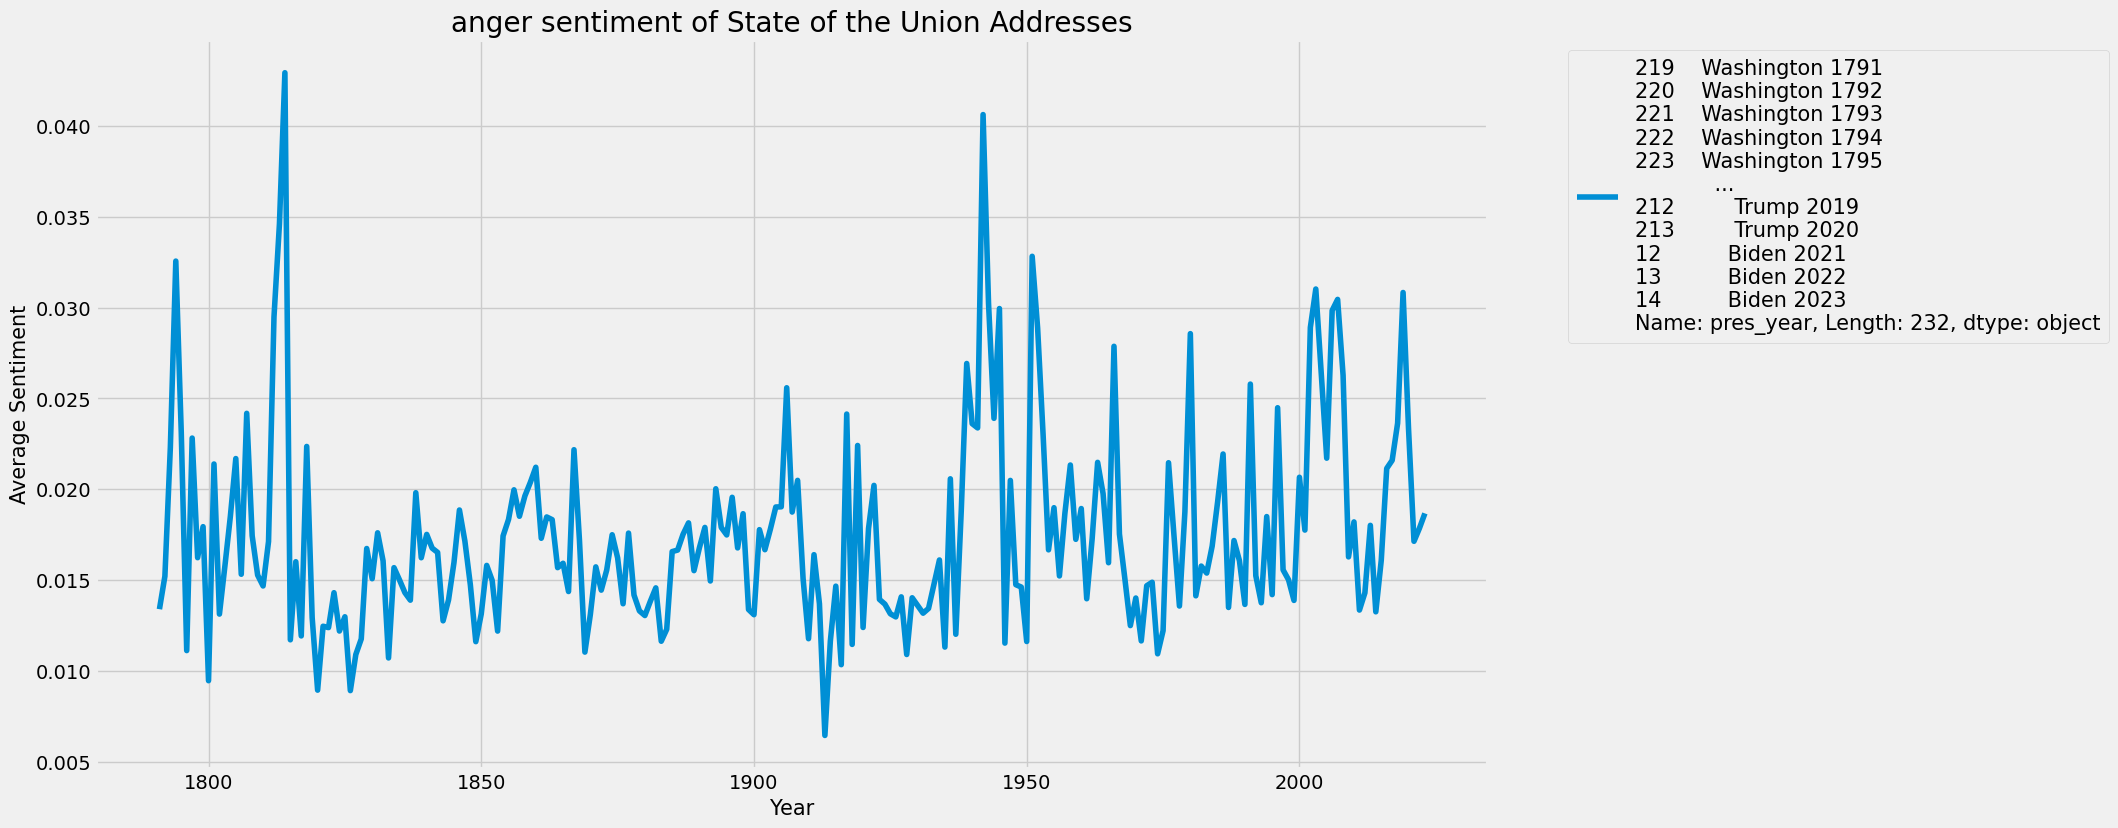

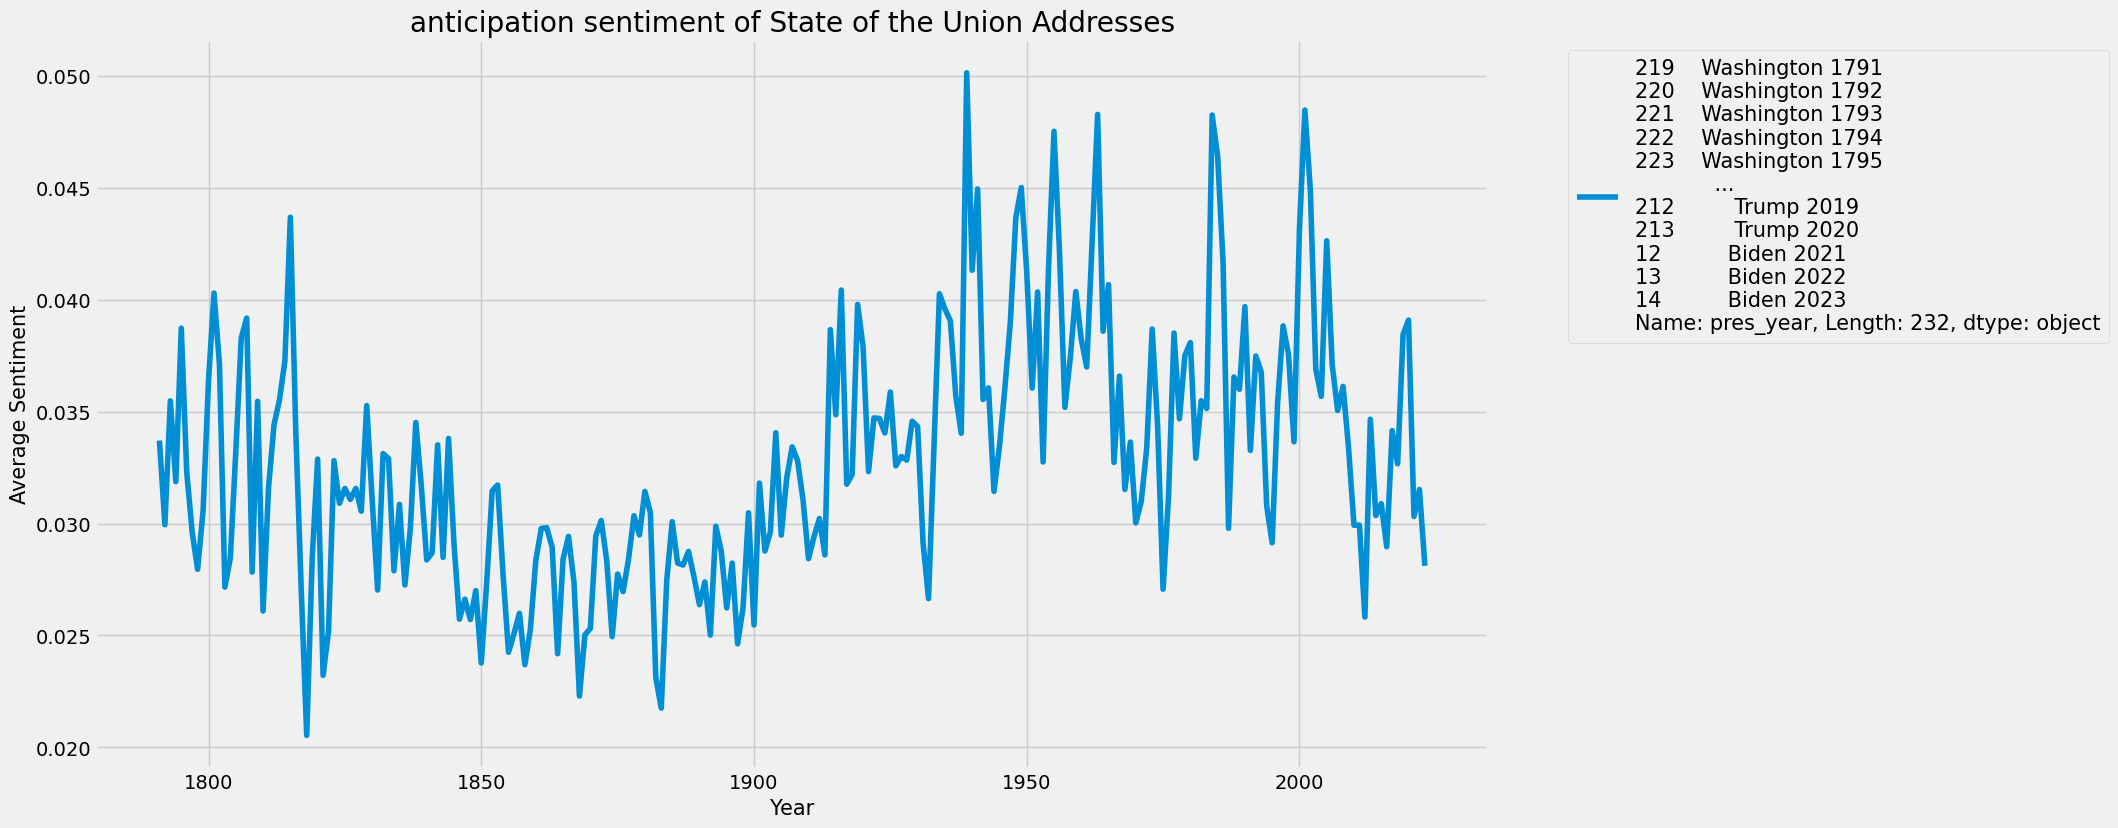

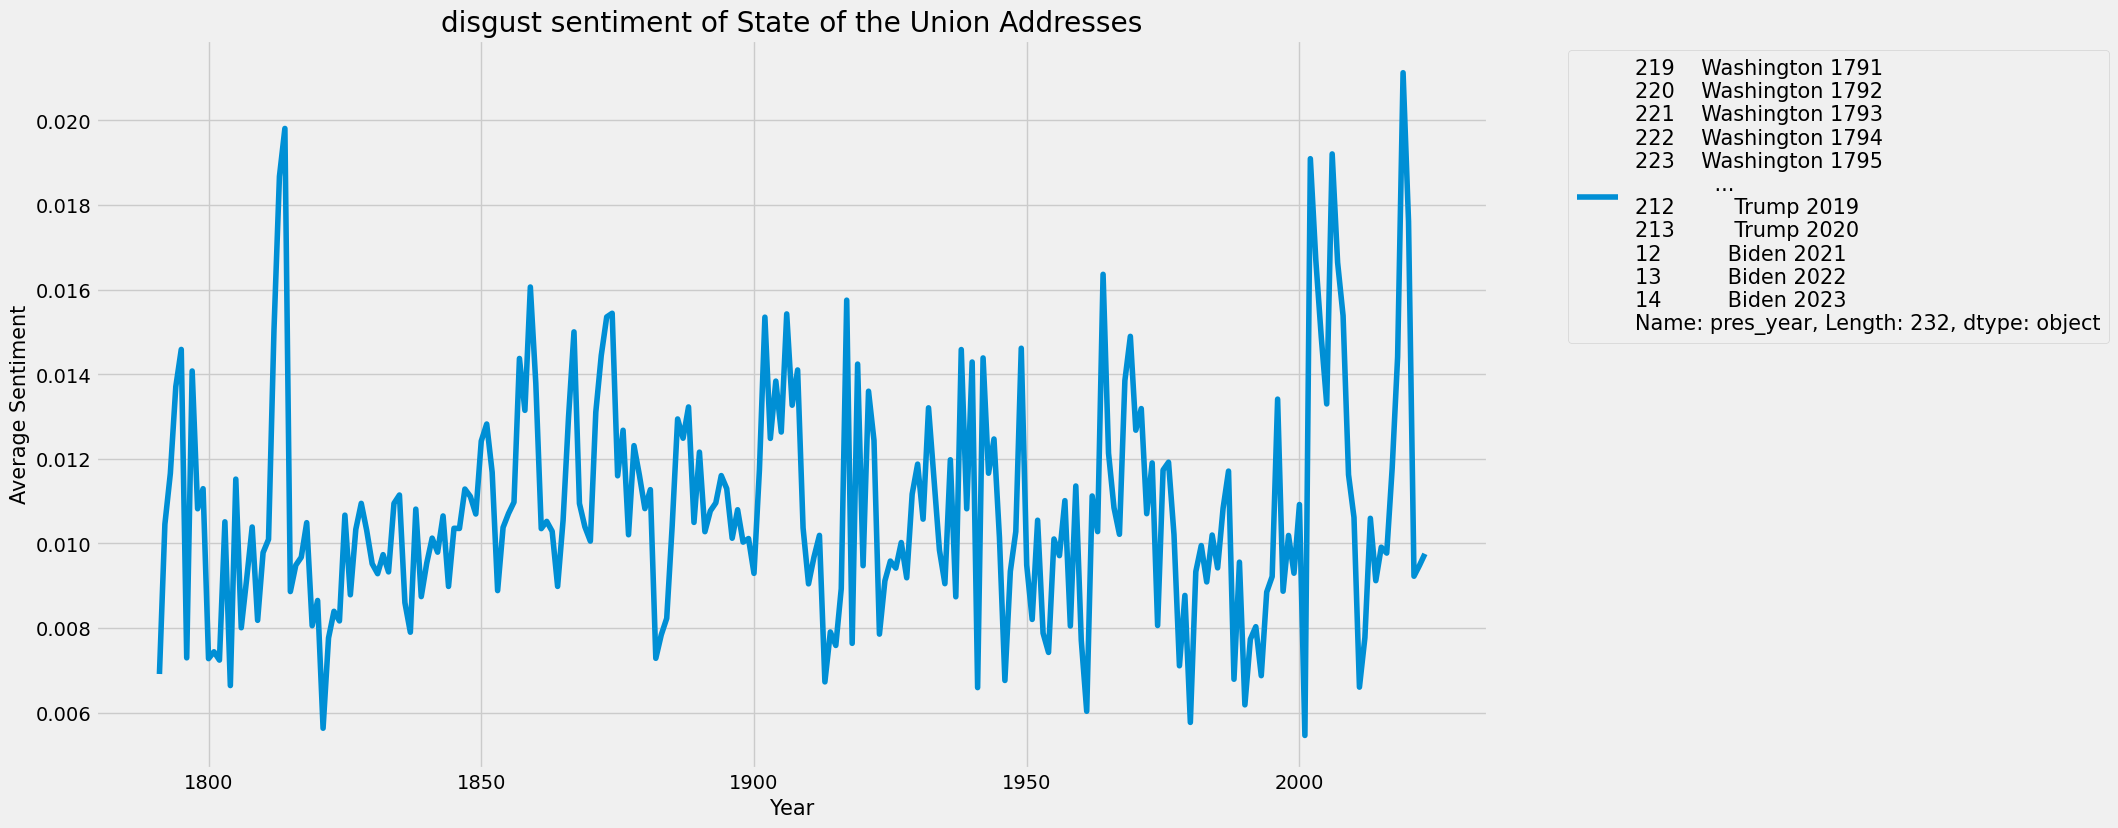

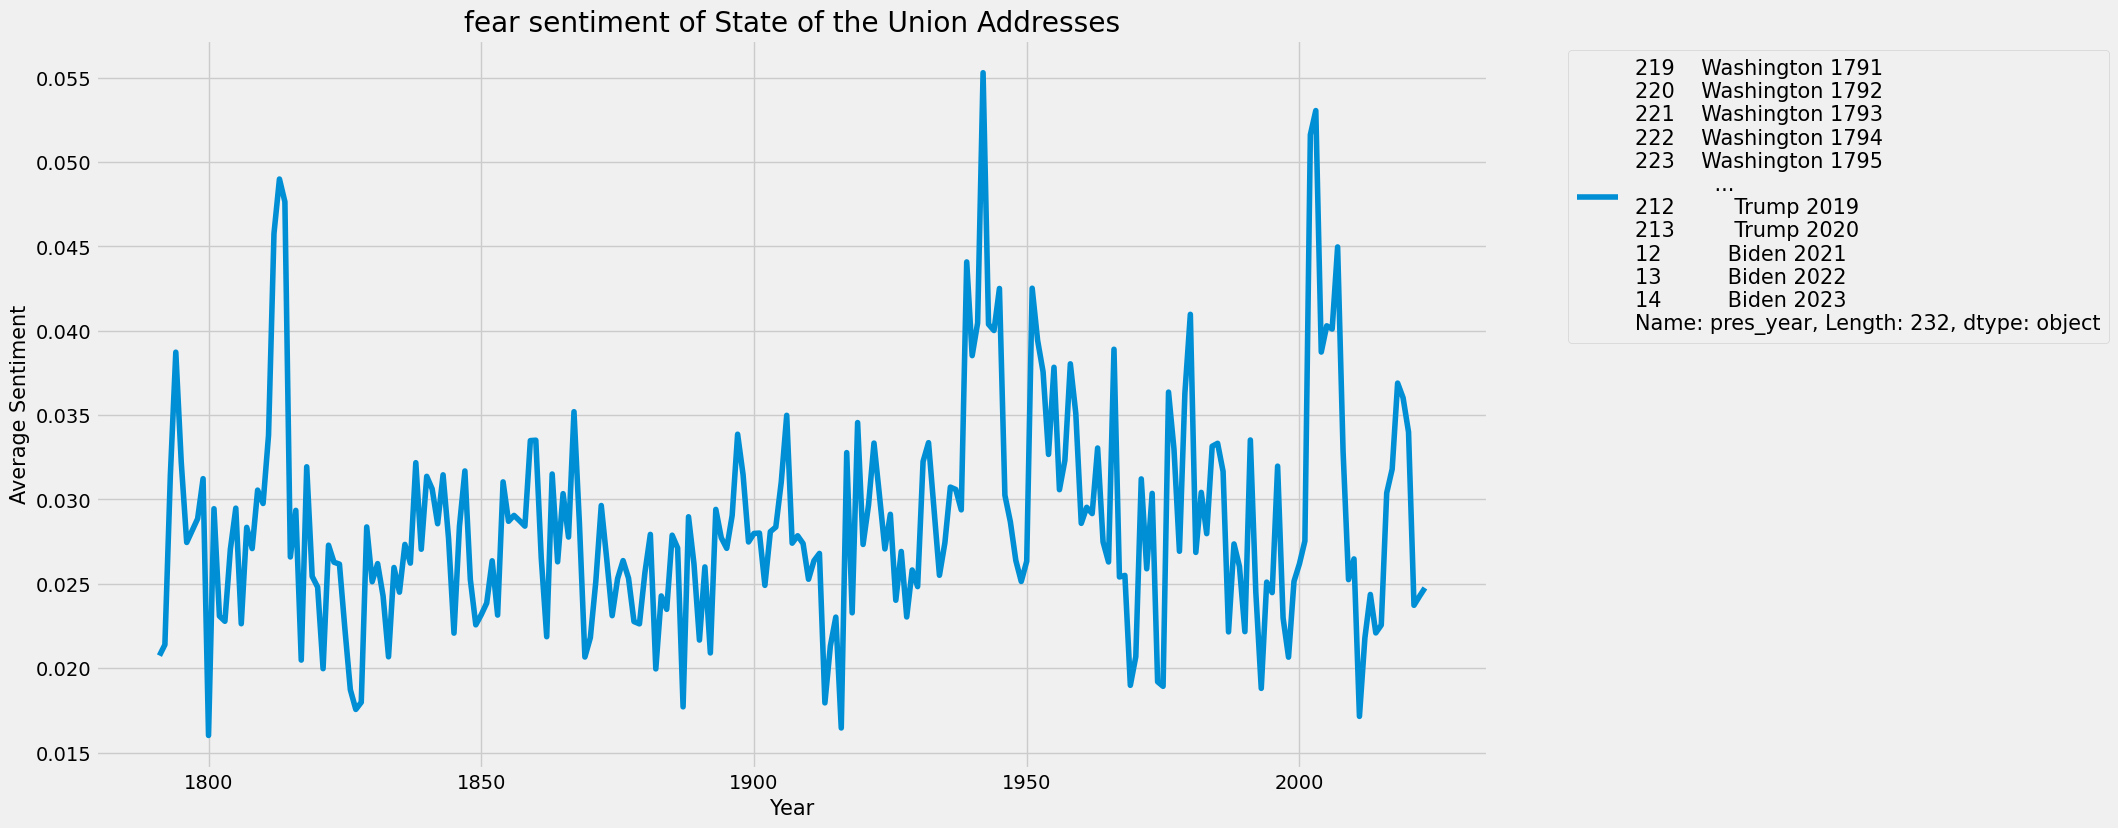

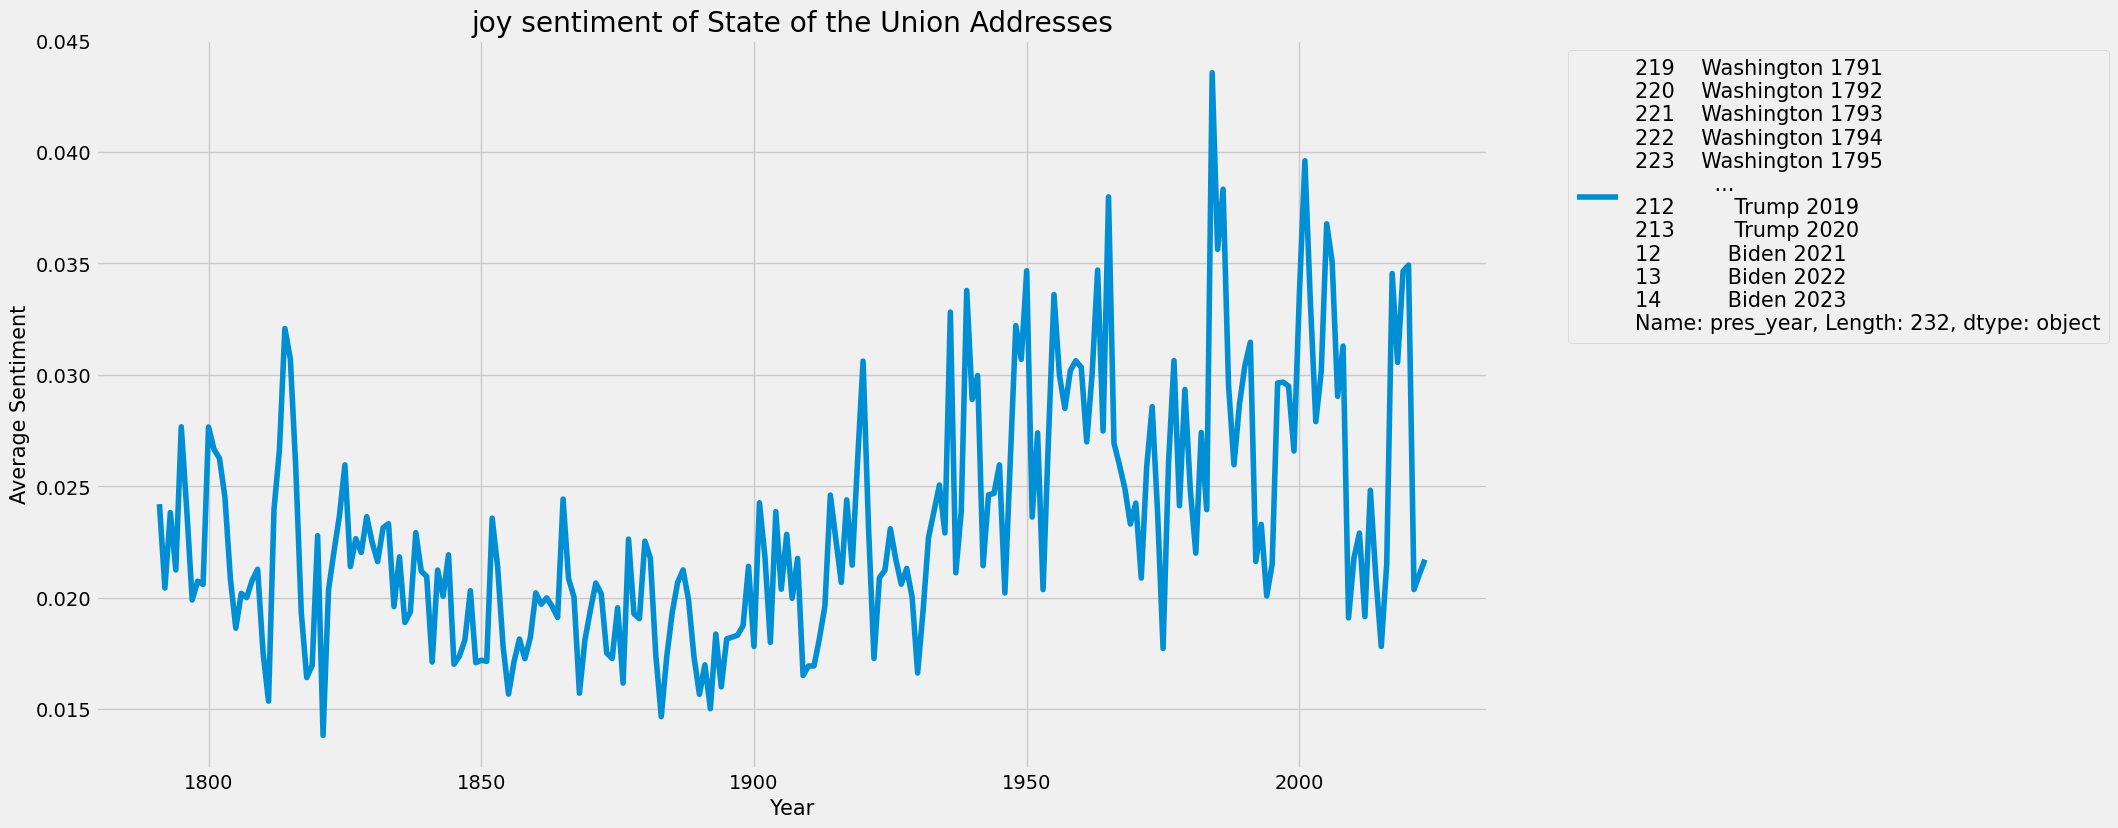

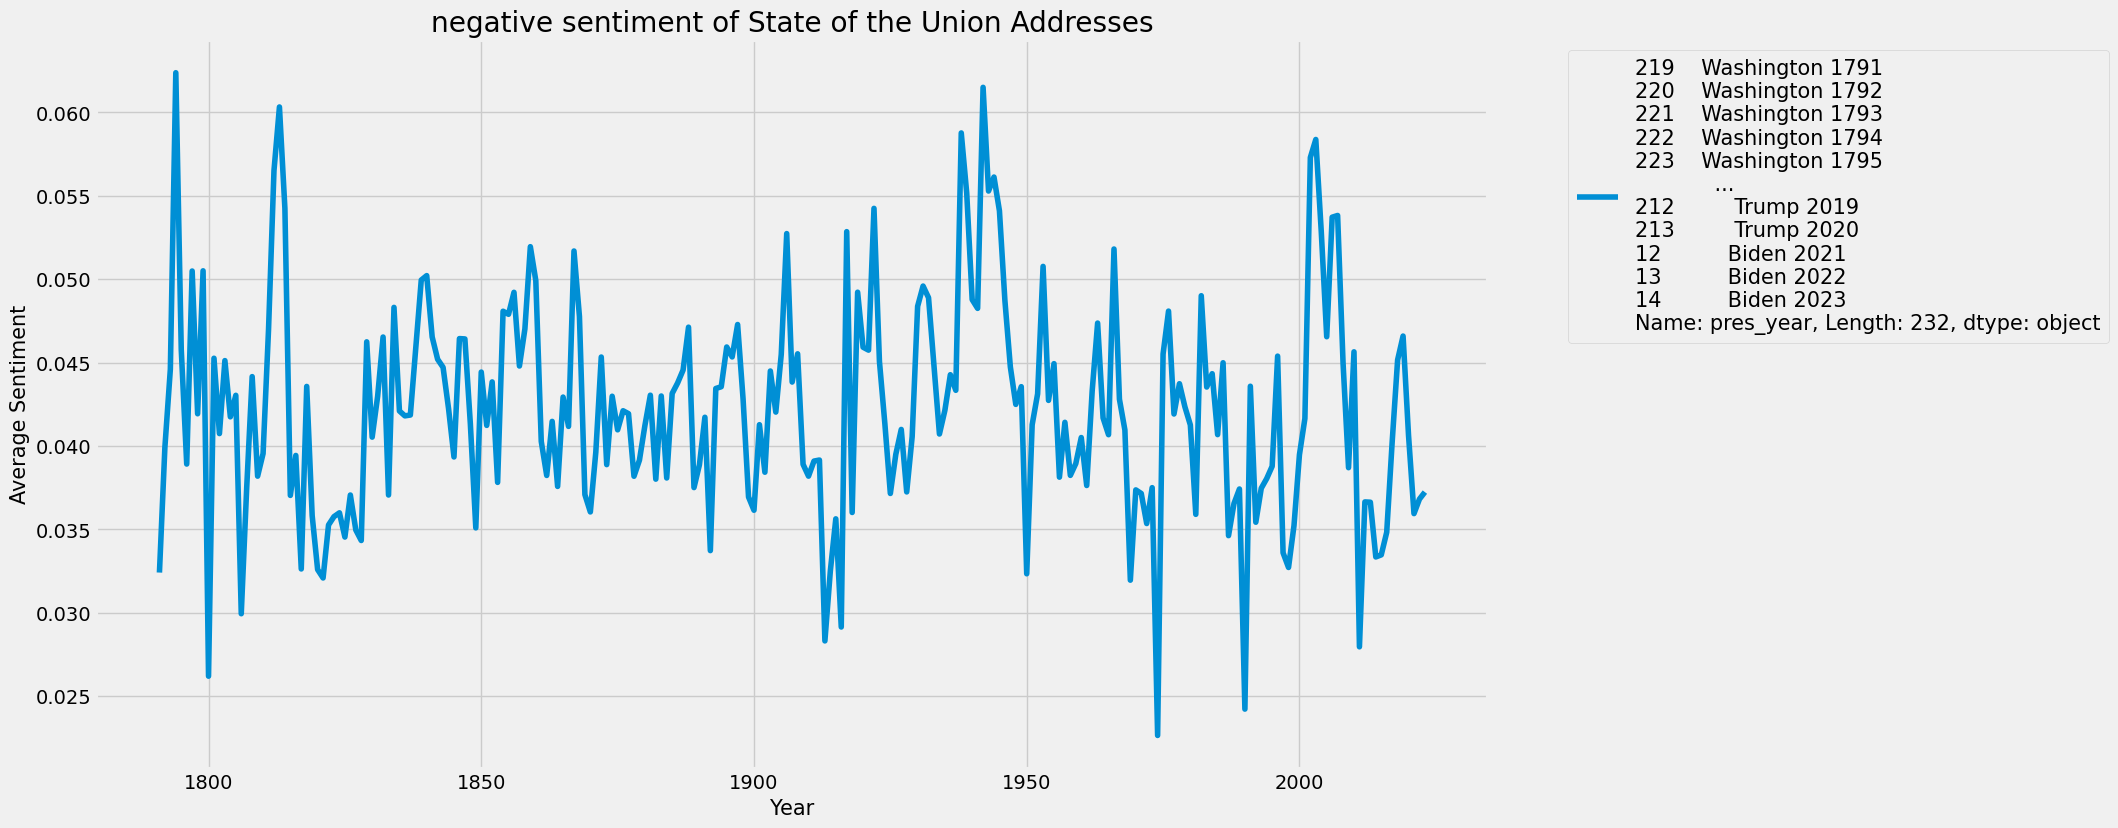

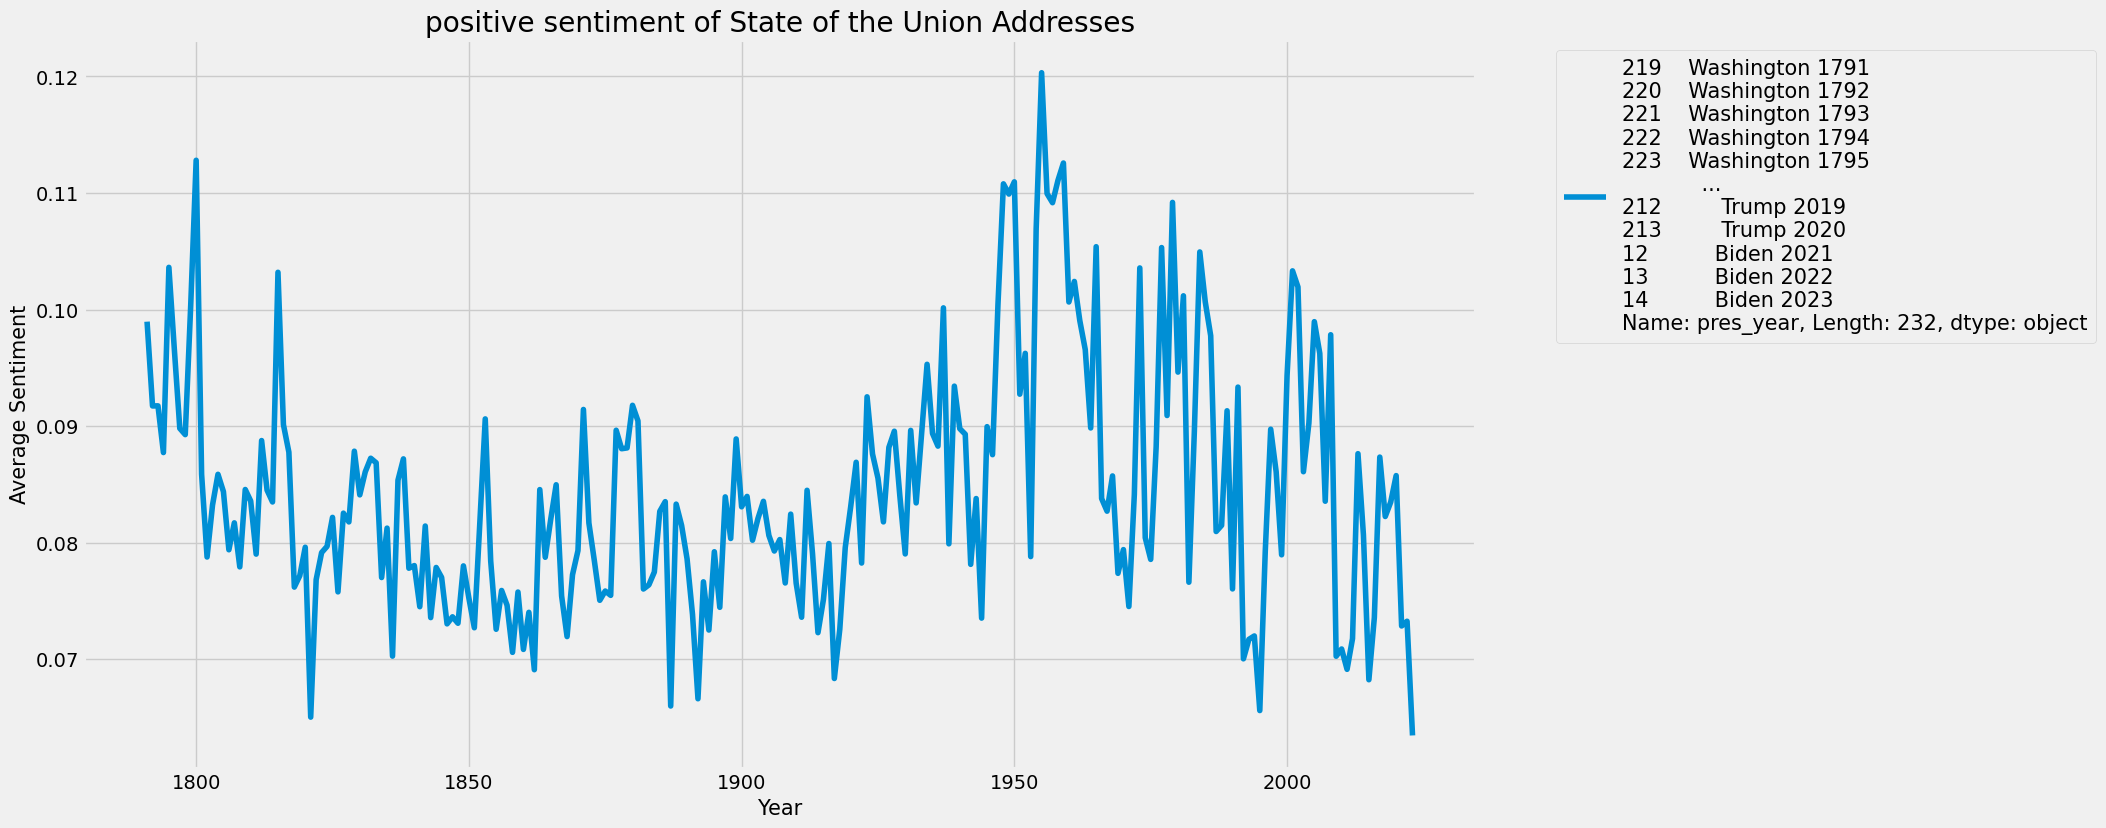

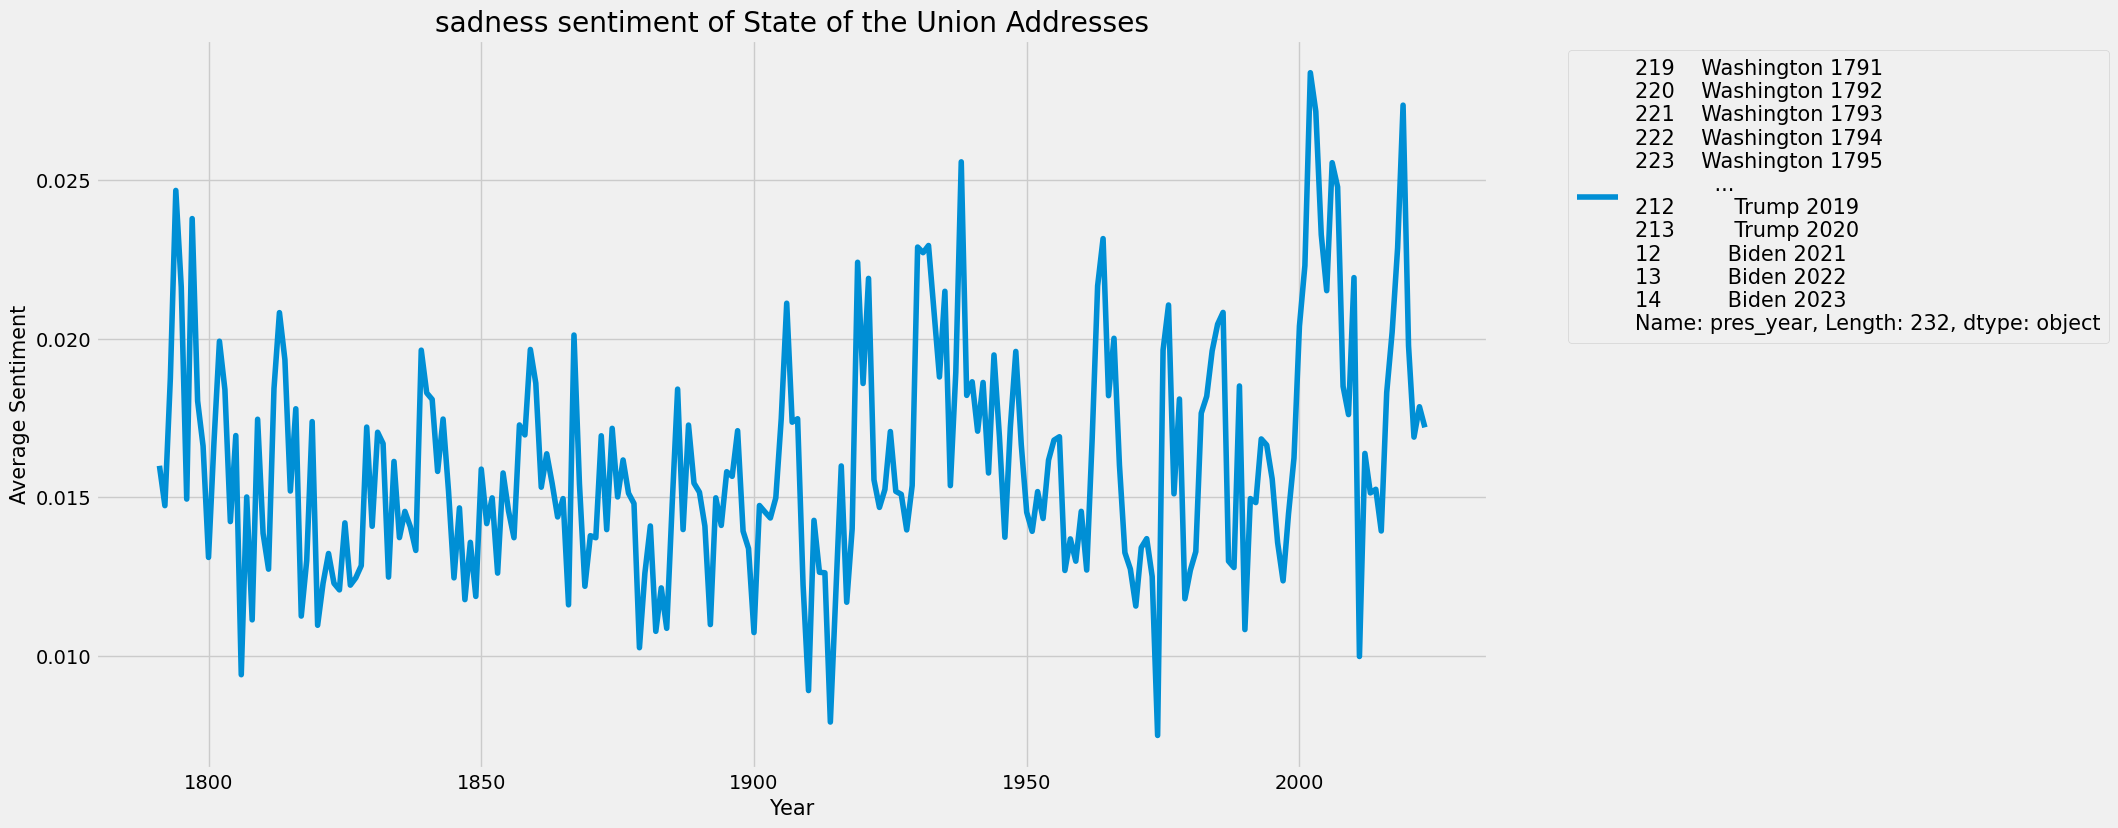

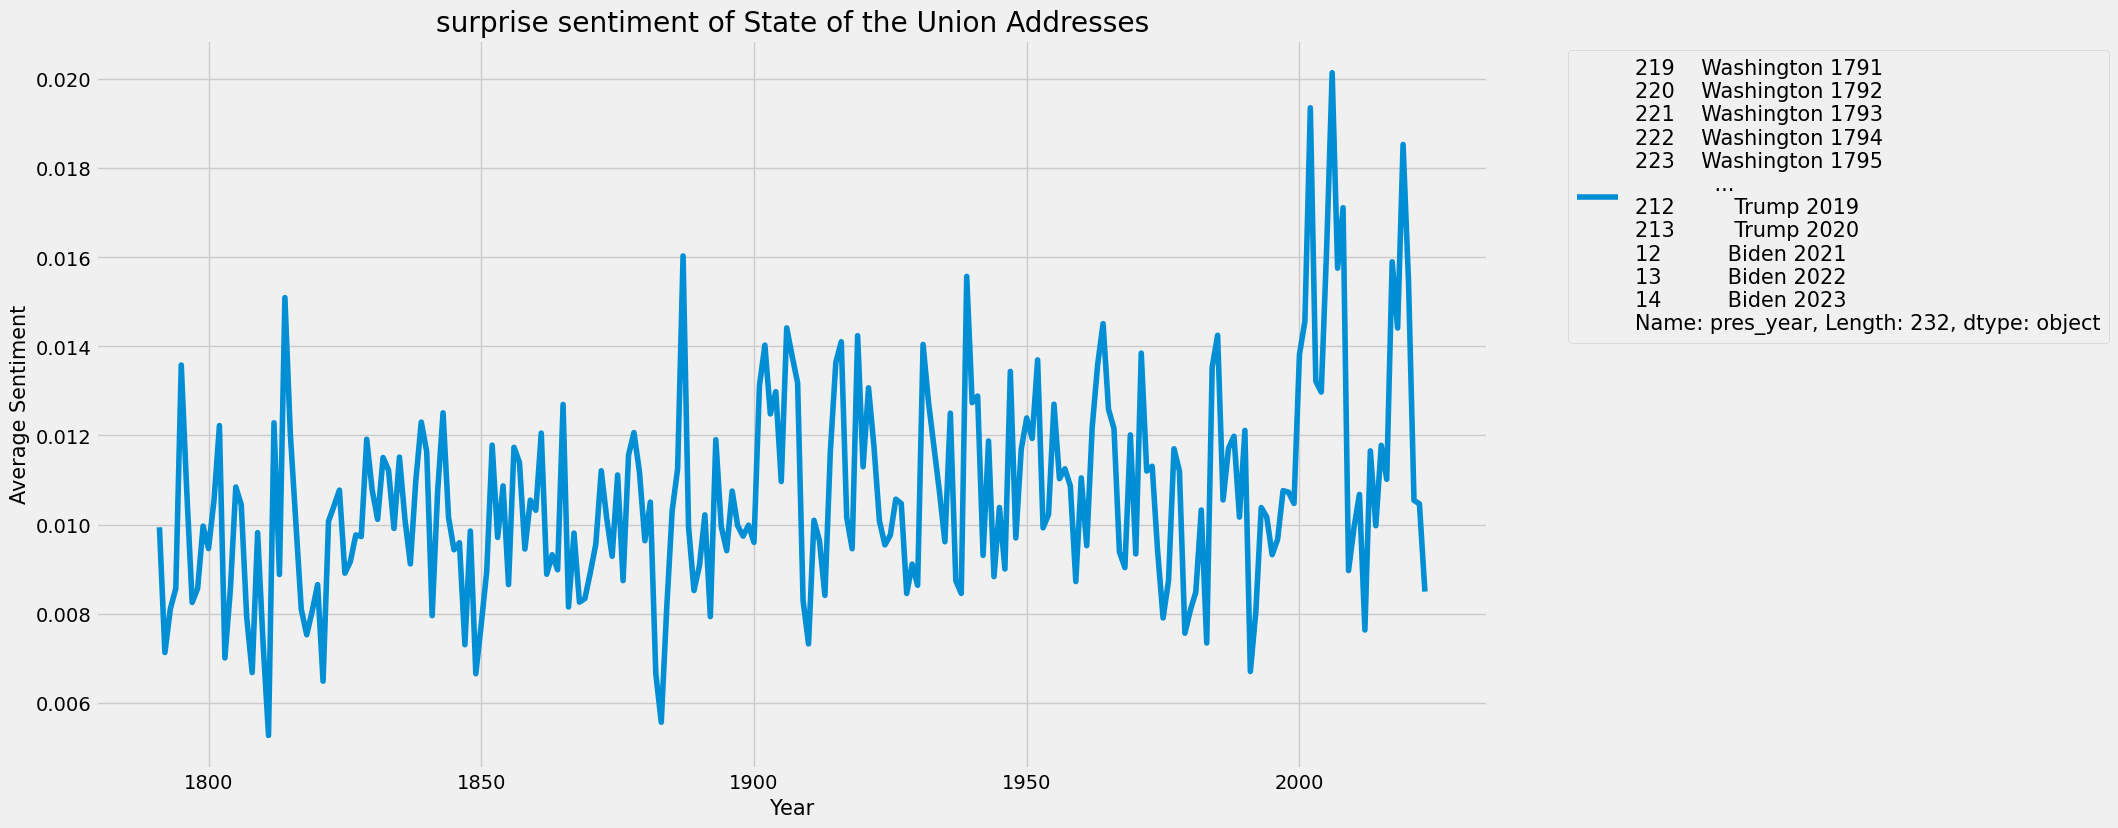

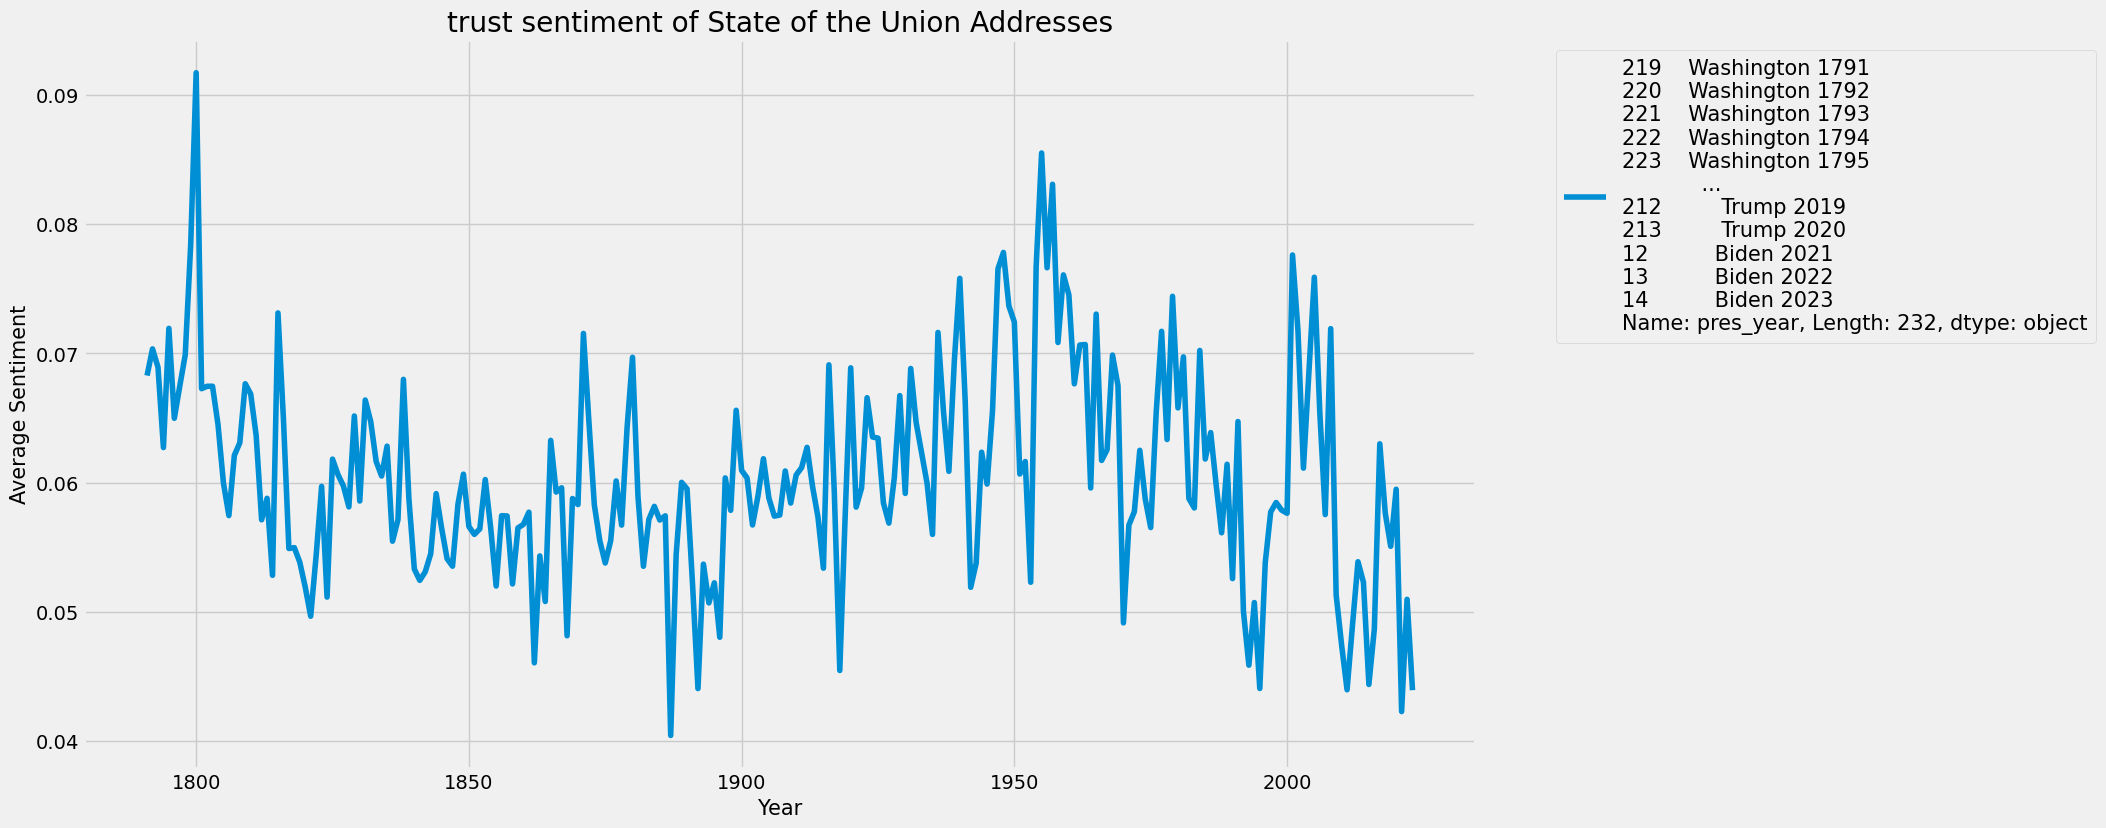

In [131]:
sotusub['pres_year'] = sotusub['pres']  + " " + sotusub['year'].astype(str)
# length = sum([len(sotudf3['word_count'])])
x = sotusub['year'].tolist()
for emotion in emotions:
    y = sotusub[emotion]
    plt.plot(x,y,label = sotusub['pres_year'])
    plt.title('{} sentiment of State of the Union Addresses'.format(emotion, fontsize=24))
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.show()

24. We can also <b style="color:red">color</b><b style="color:blue">-code</b> <b style="color:green">this</b> <b style="color:orange">data</b> <b style="color:purple">by president</b>. We can use the **.shift()** and **.cumsum()** functions to label each administration and then the **groupby()** function to create a list of years for each successive presidential administration.

In [132]:
sotusub["presnum"] = (sotusub["pres"] != sotusub["pres"].shift()).cumsum()
presdf = sotusub[["pres","year","presnum","pres_year"]]
presdf.to_csv("pres_sotulist.csv",encoding='utf-8')
presyears = presdf.groupby('presnum')['year'].apply(list)
print(presyears[-10:])

presnum
35                      [1970, 1971, 1972, 1973, 1974]
36                                  [1975, 1976, 1977]
37                            [1978, 1979, 1980, 1981]
38          [1982, 1983, 1984, 1985, 1986, 1987, 1988]
39                            [1989, 1990, 1991, 1992]
40    [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]
41    [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
42    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
43                            [2017, 2018, 2019, 2020]
44                                  [2021, 2022, 2023]
Name: year, dtype: object


25. Now, we can modify our plot code from above to color-code each presidential administration and to add a line to show the moving average of each emotion or sentiment.

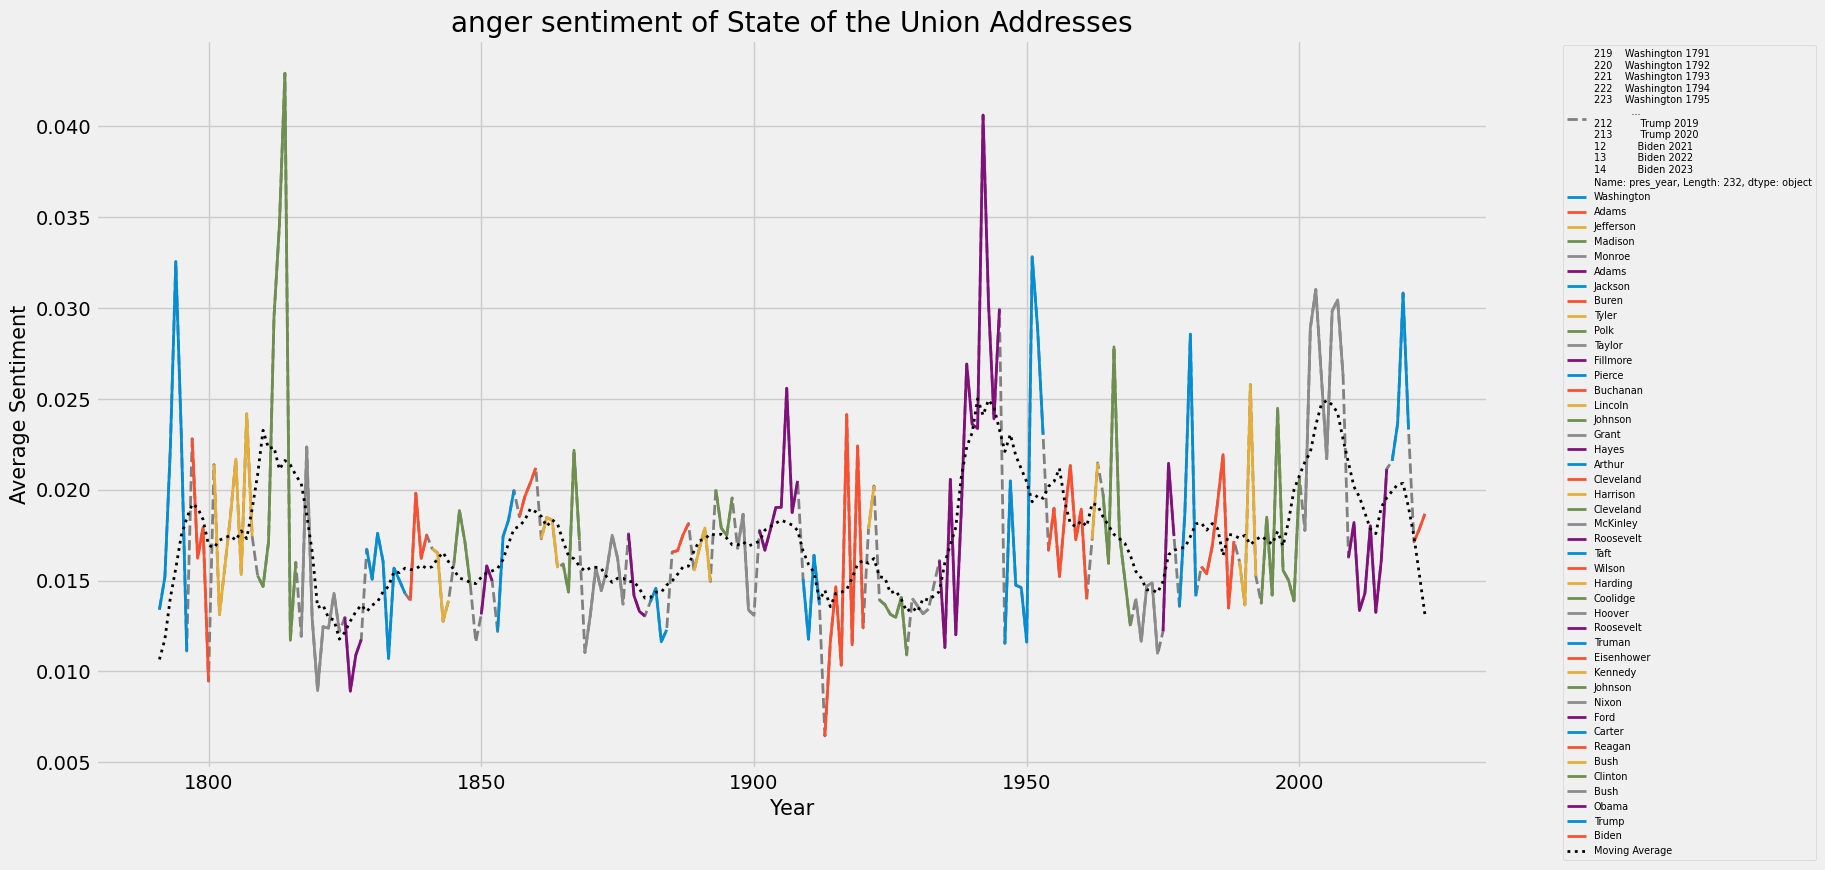

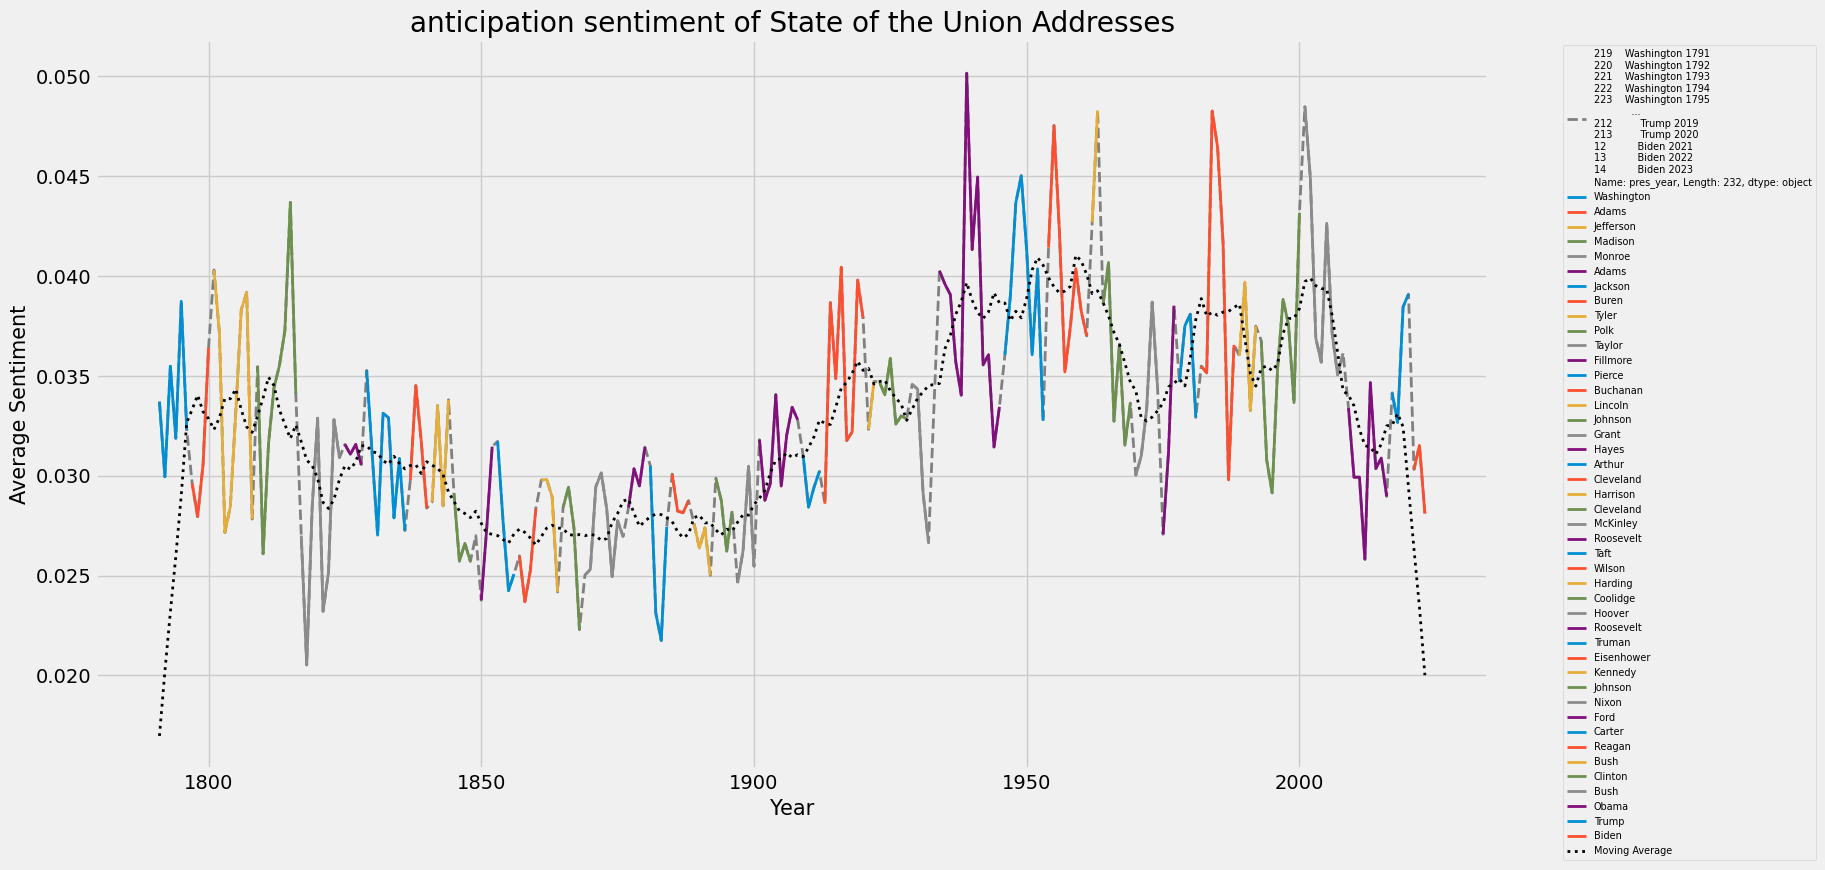

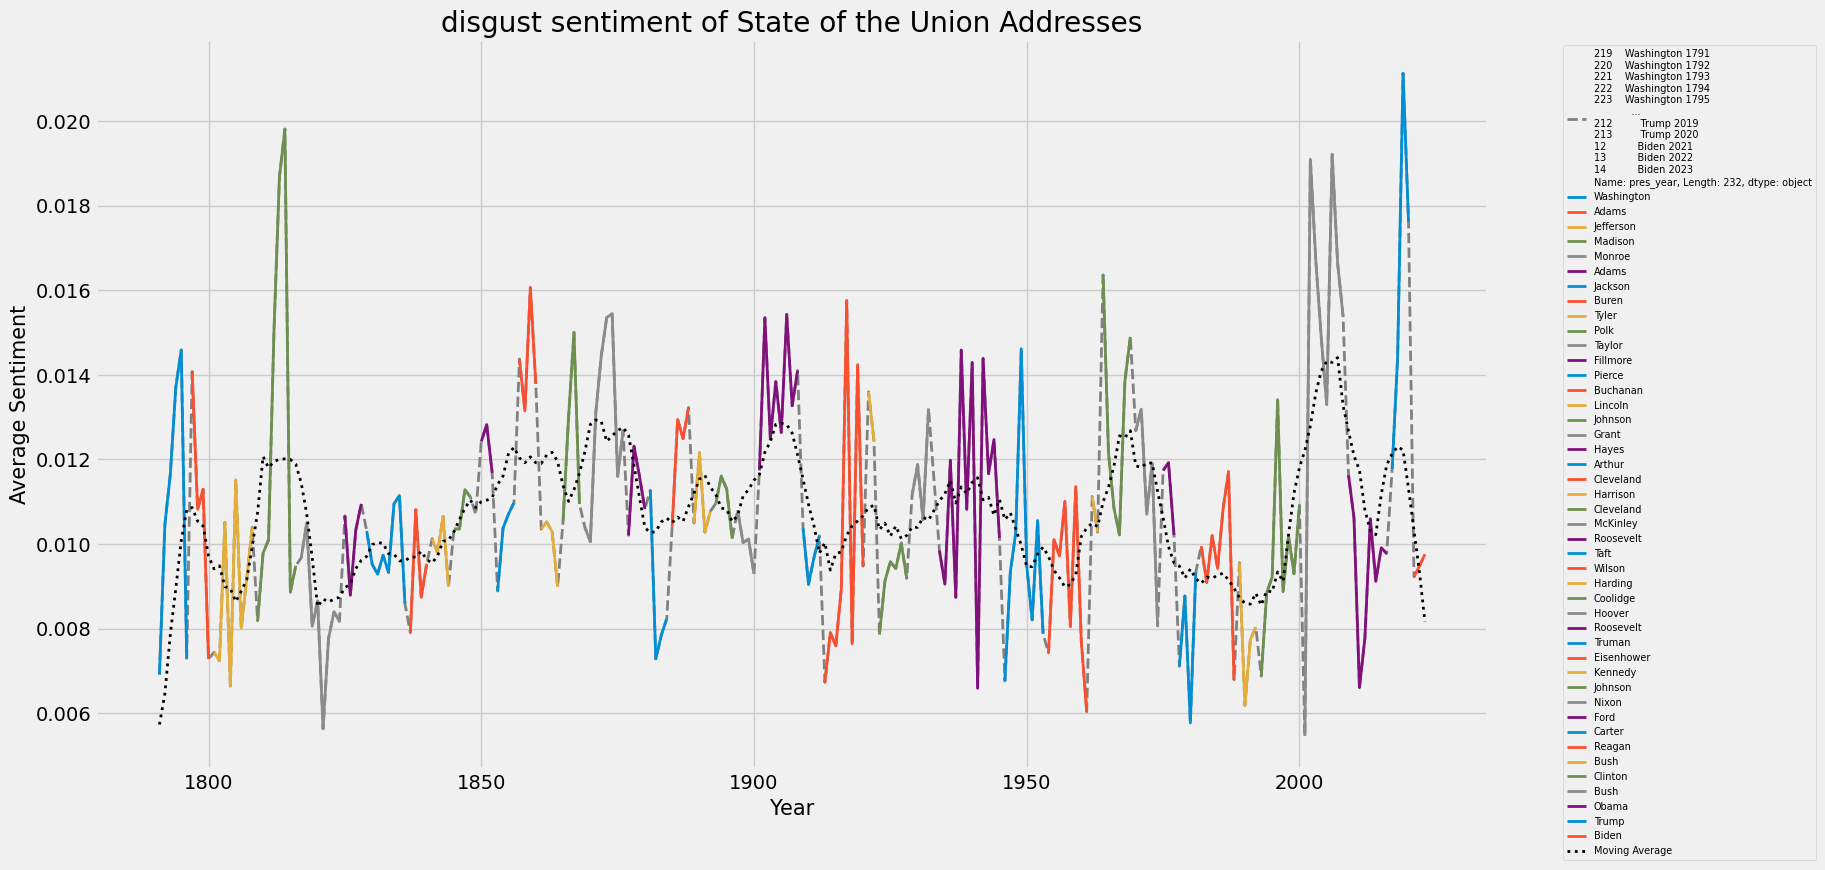

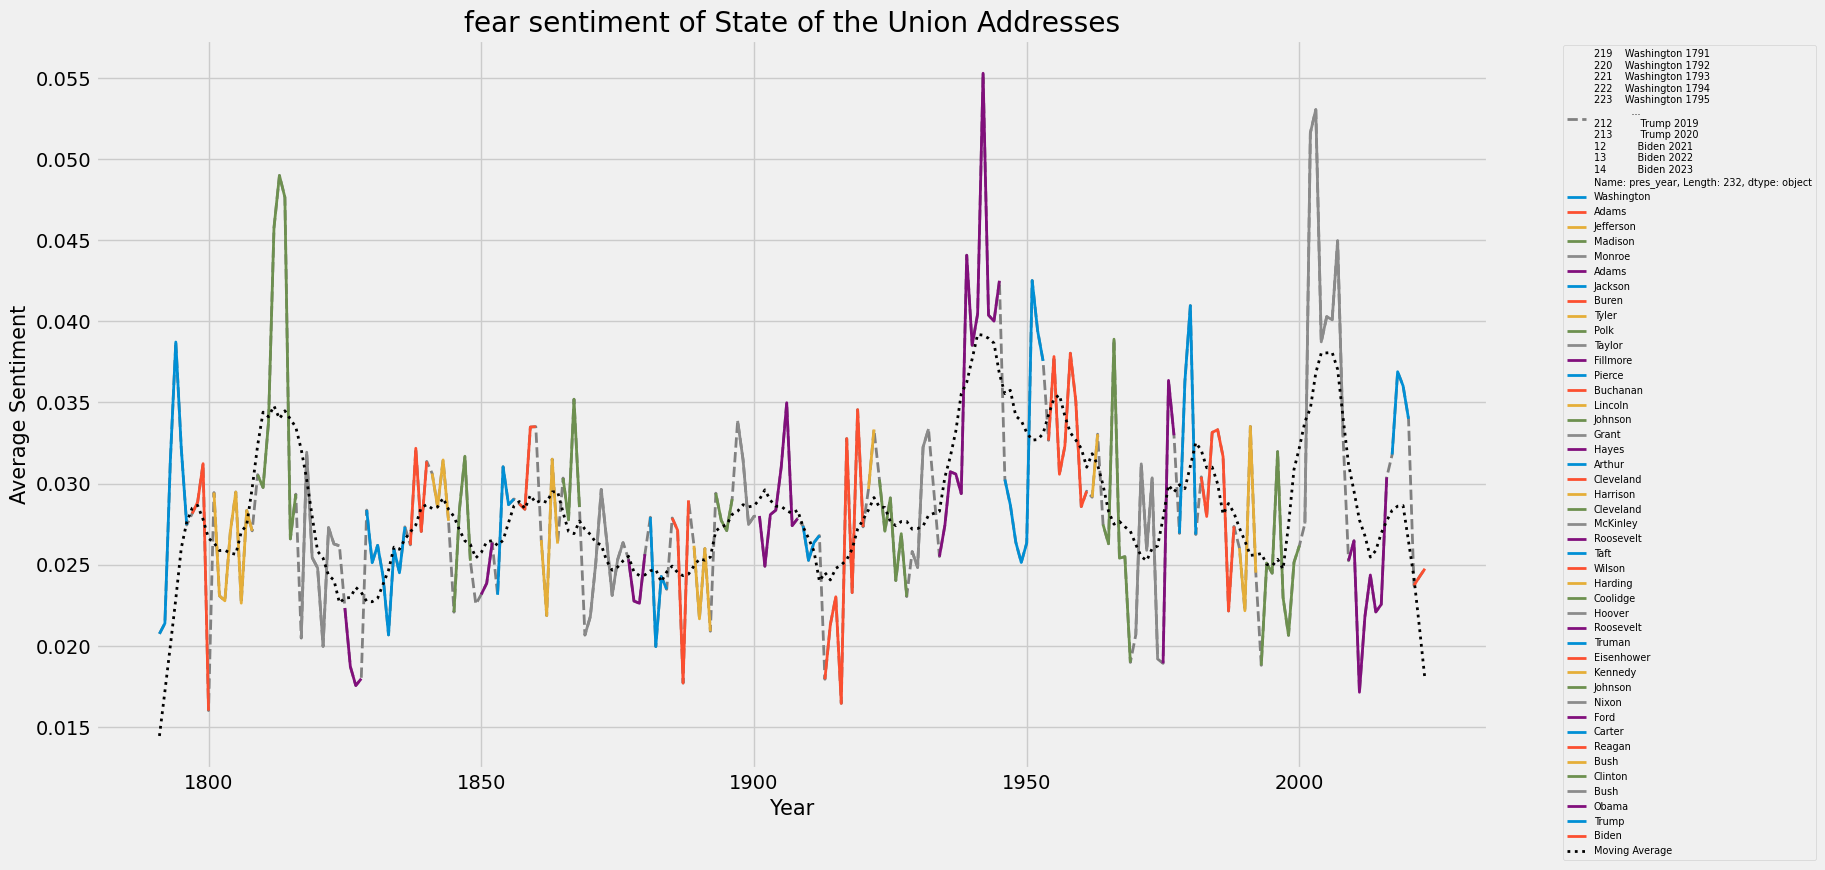

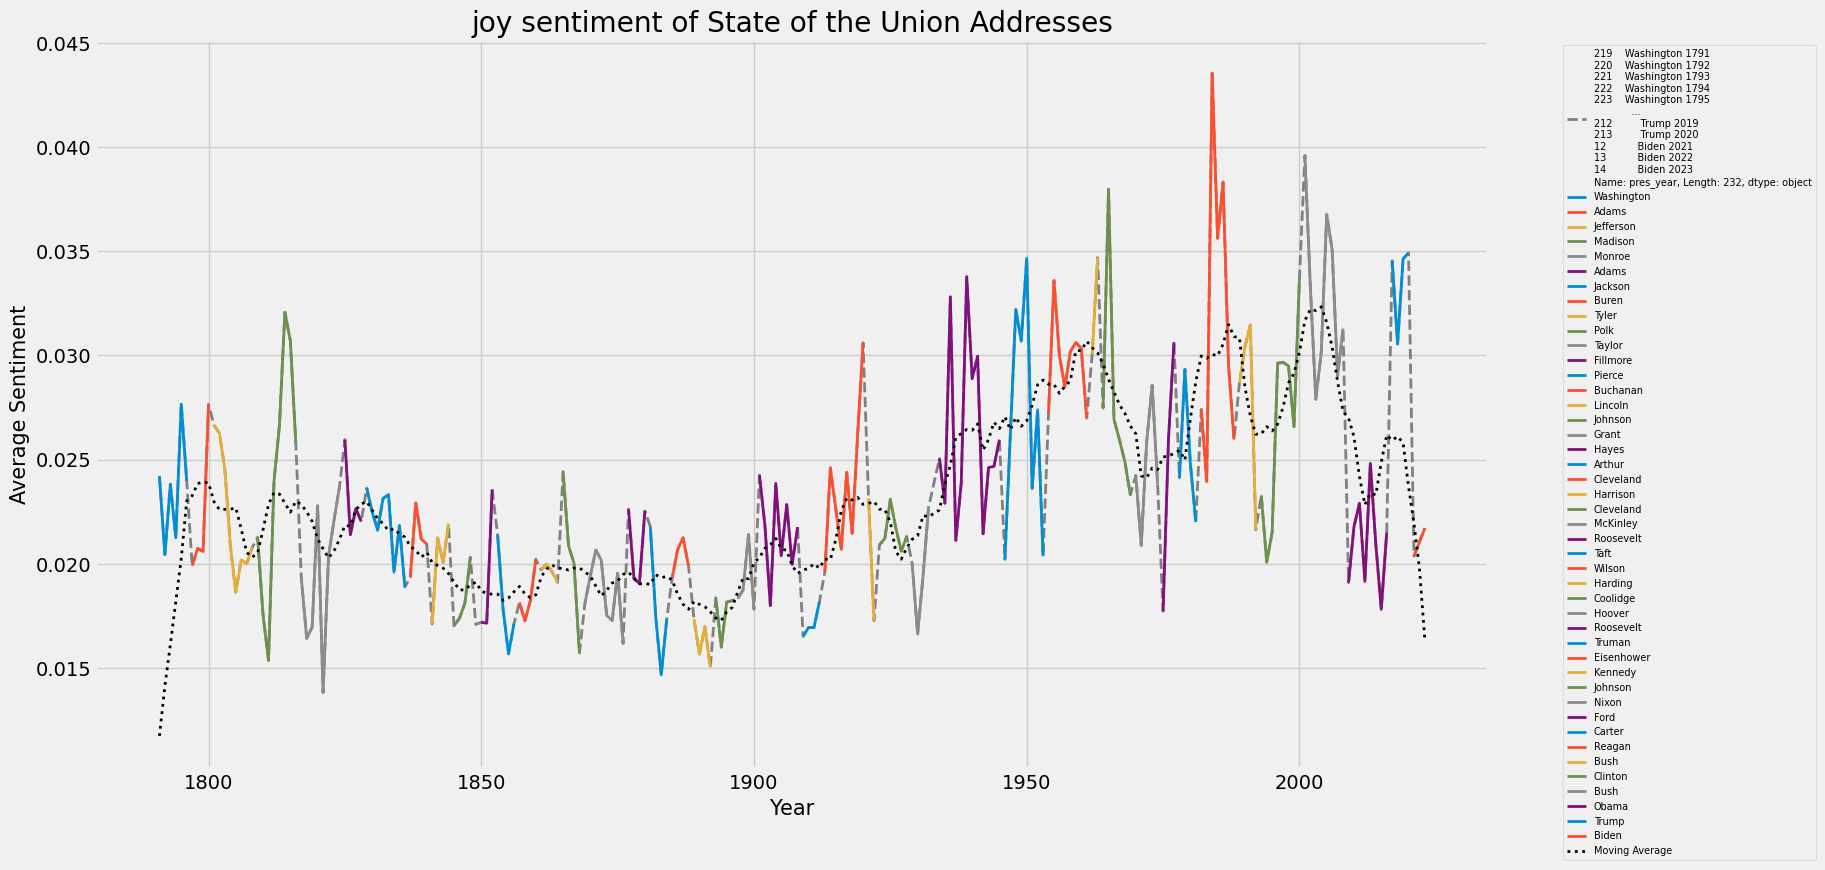

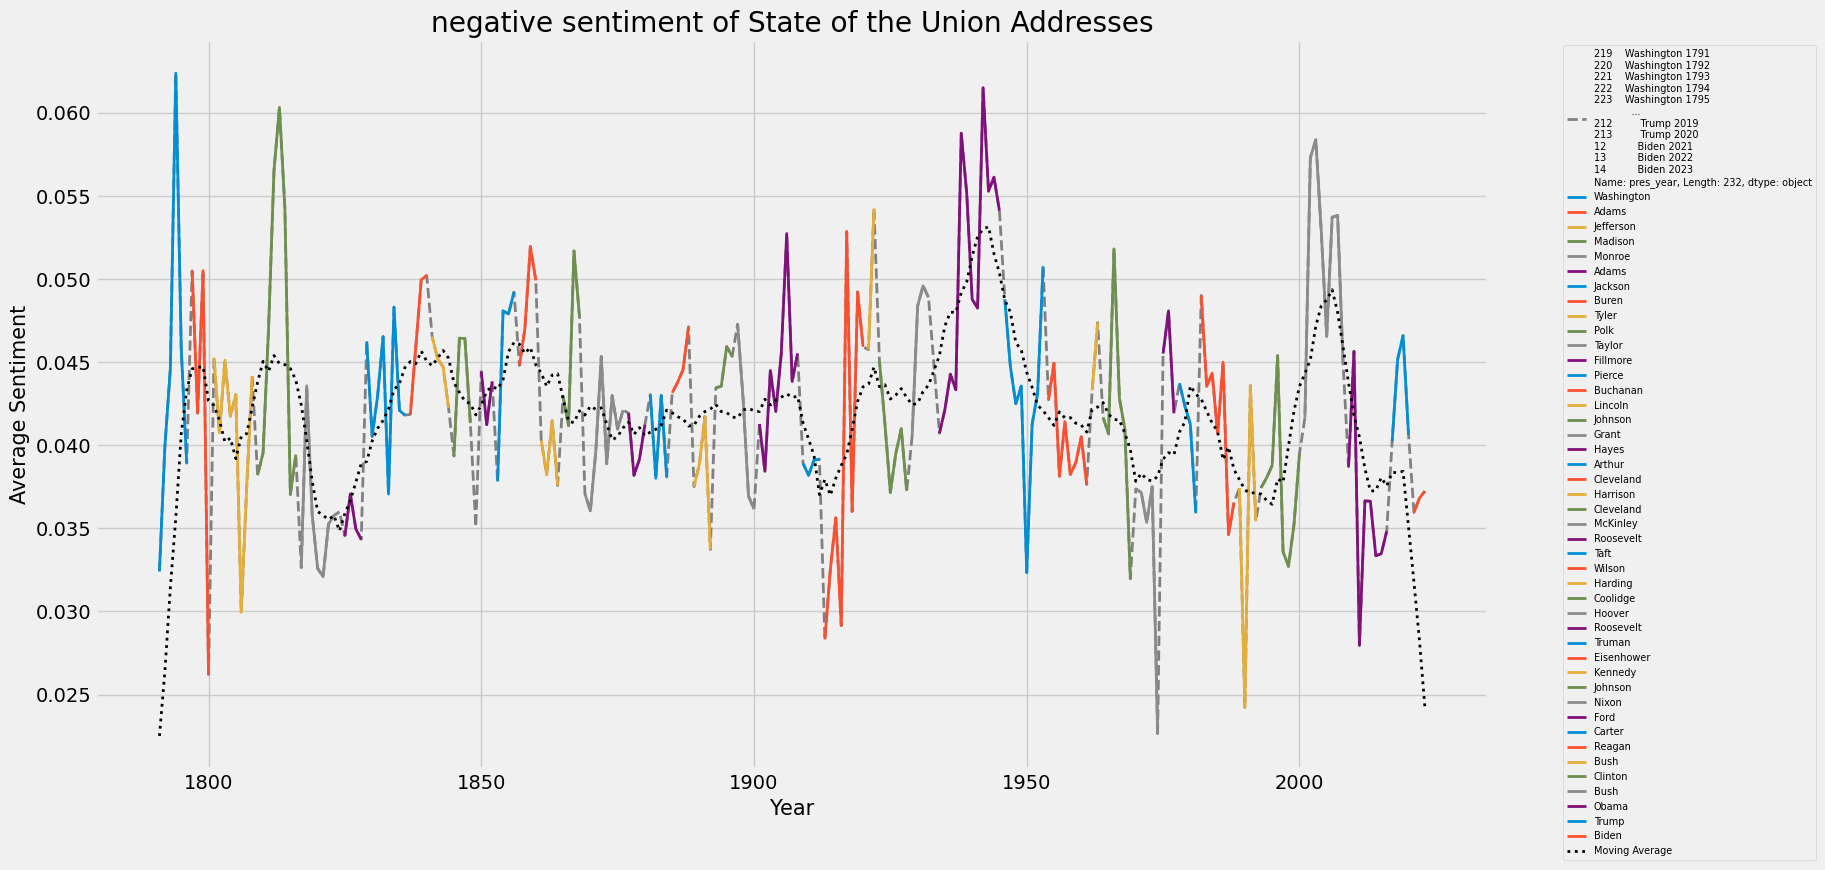

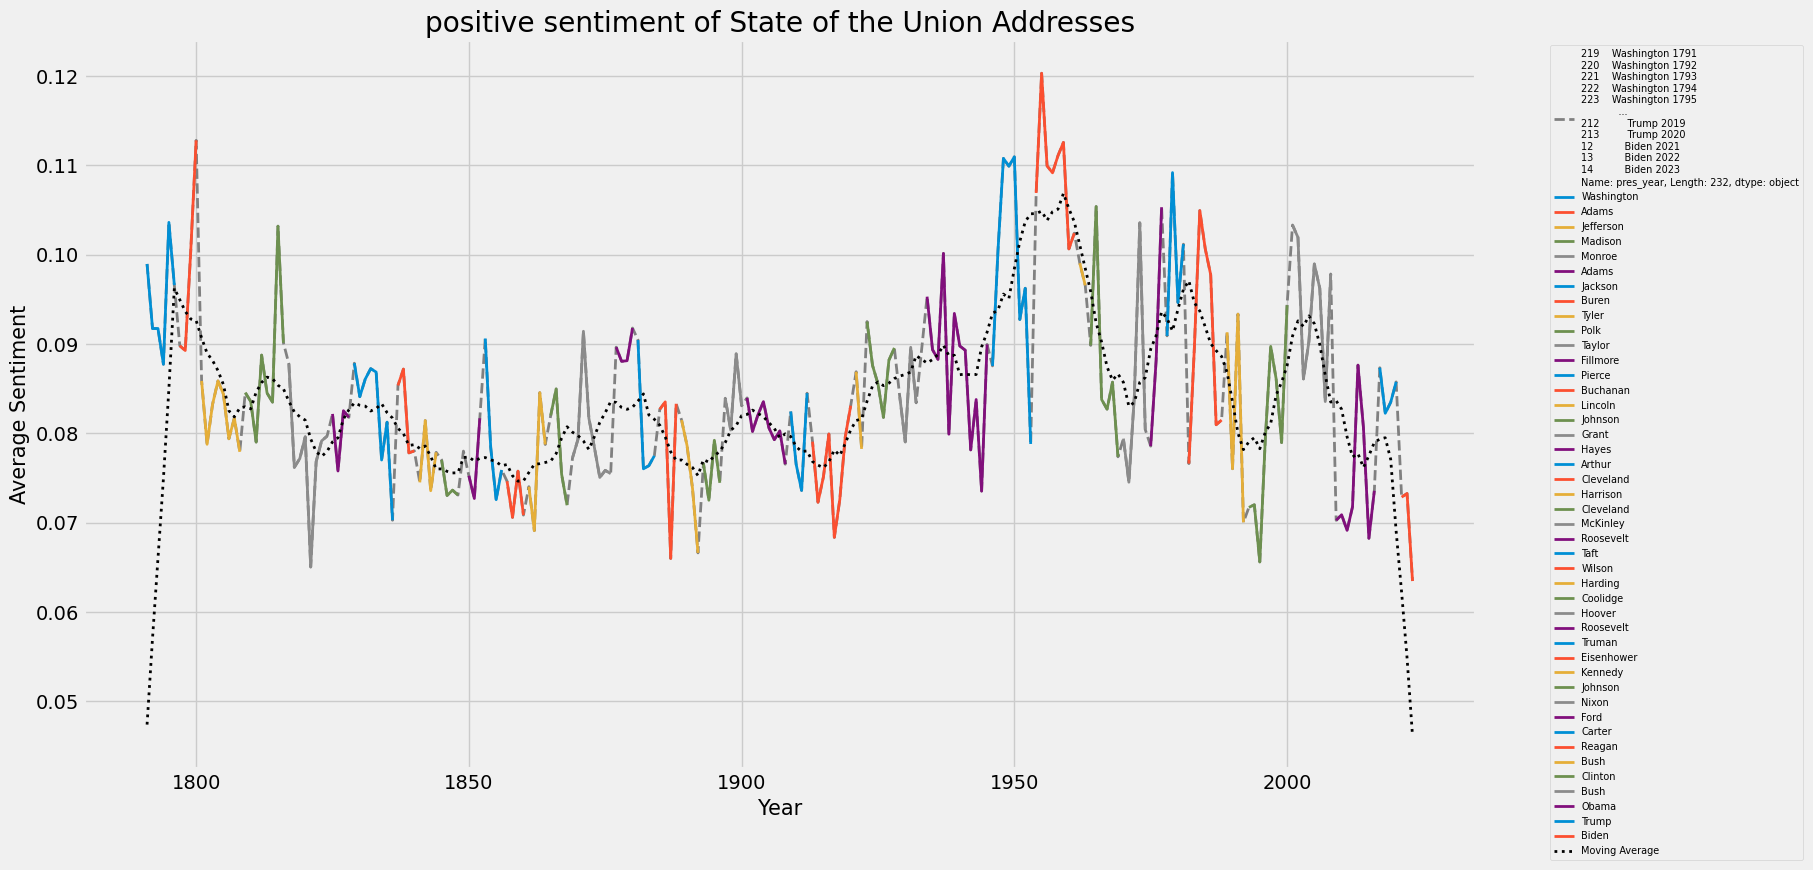

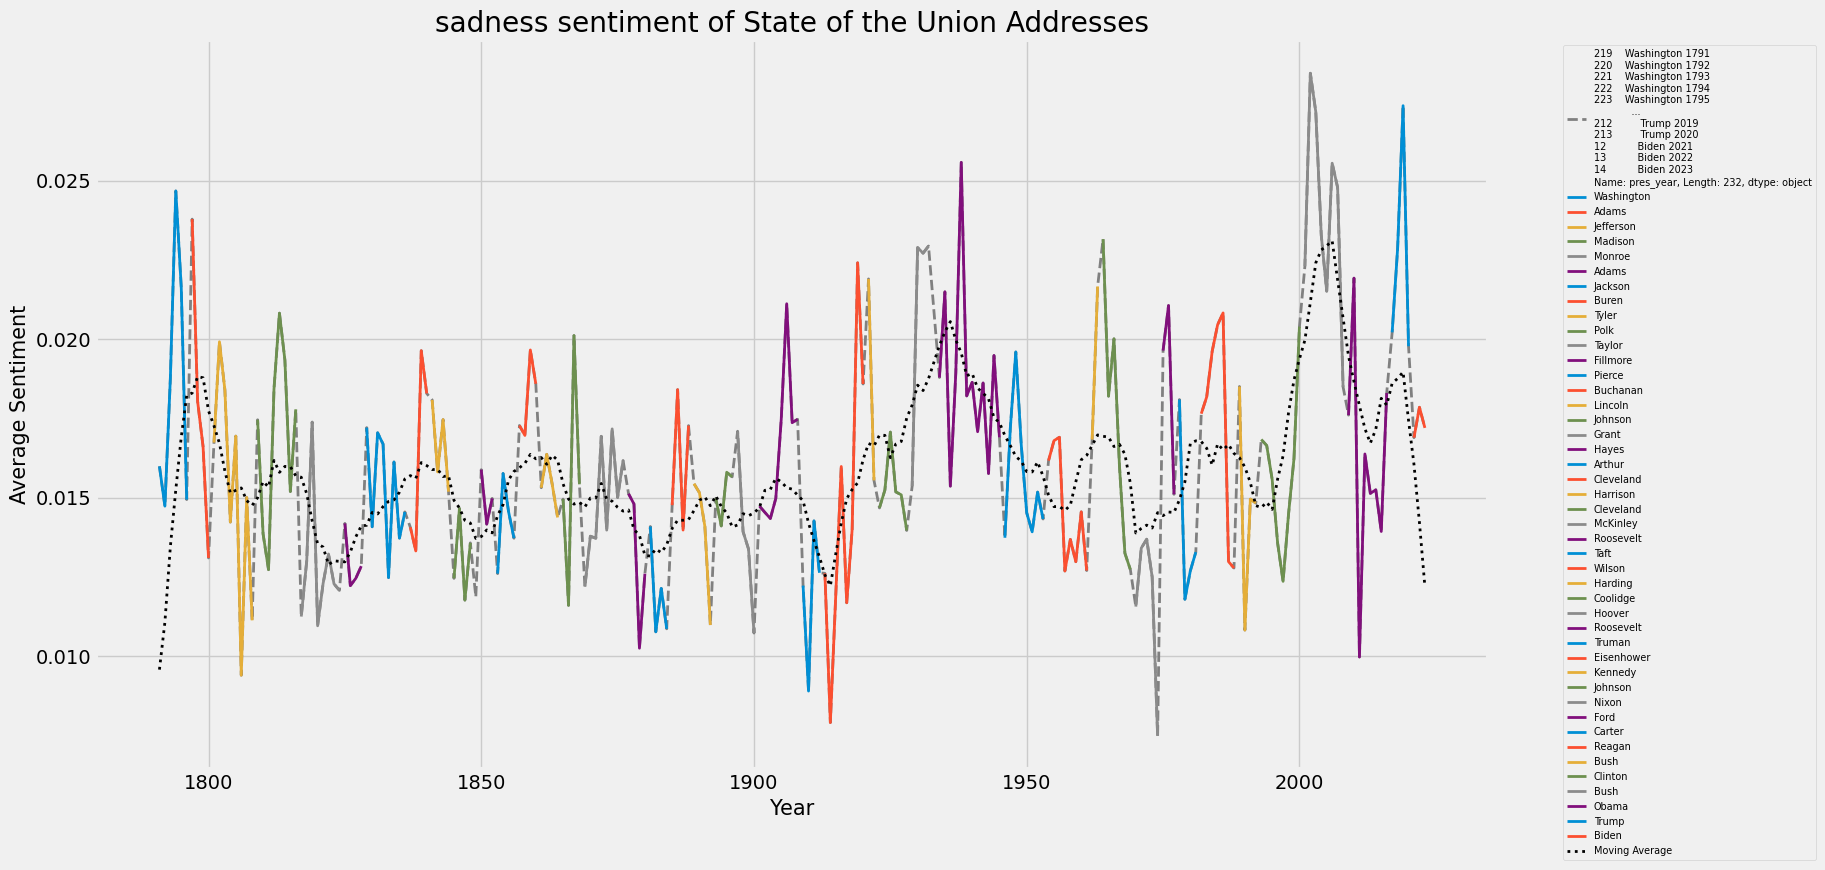

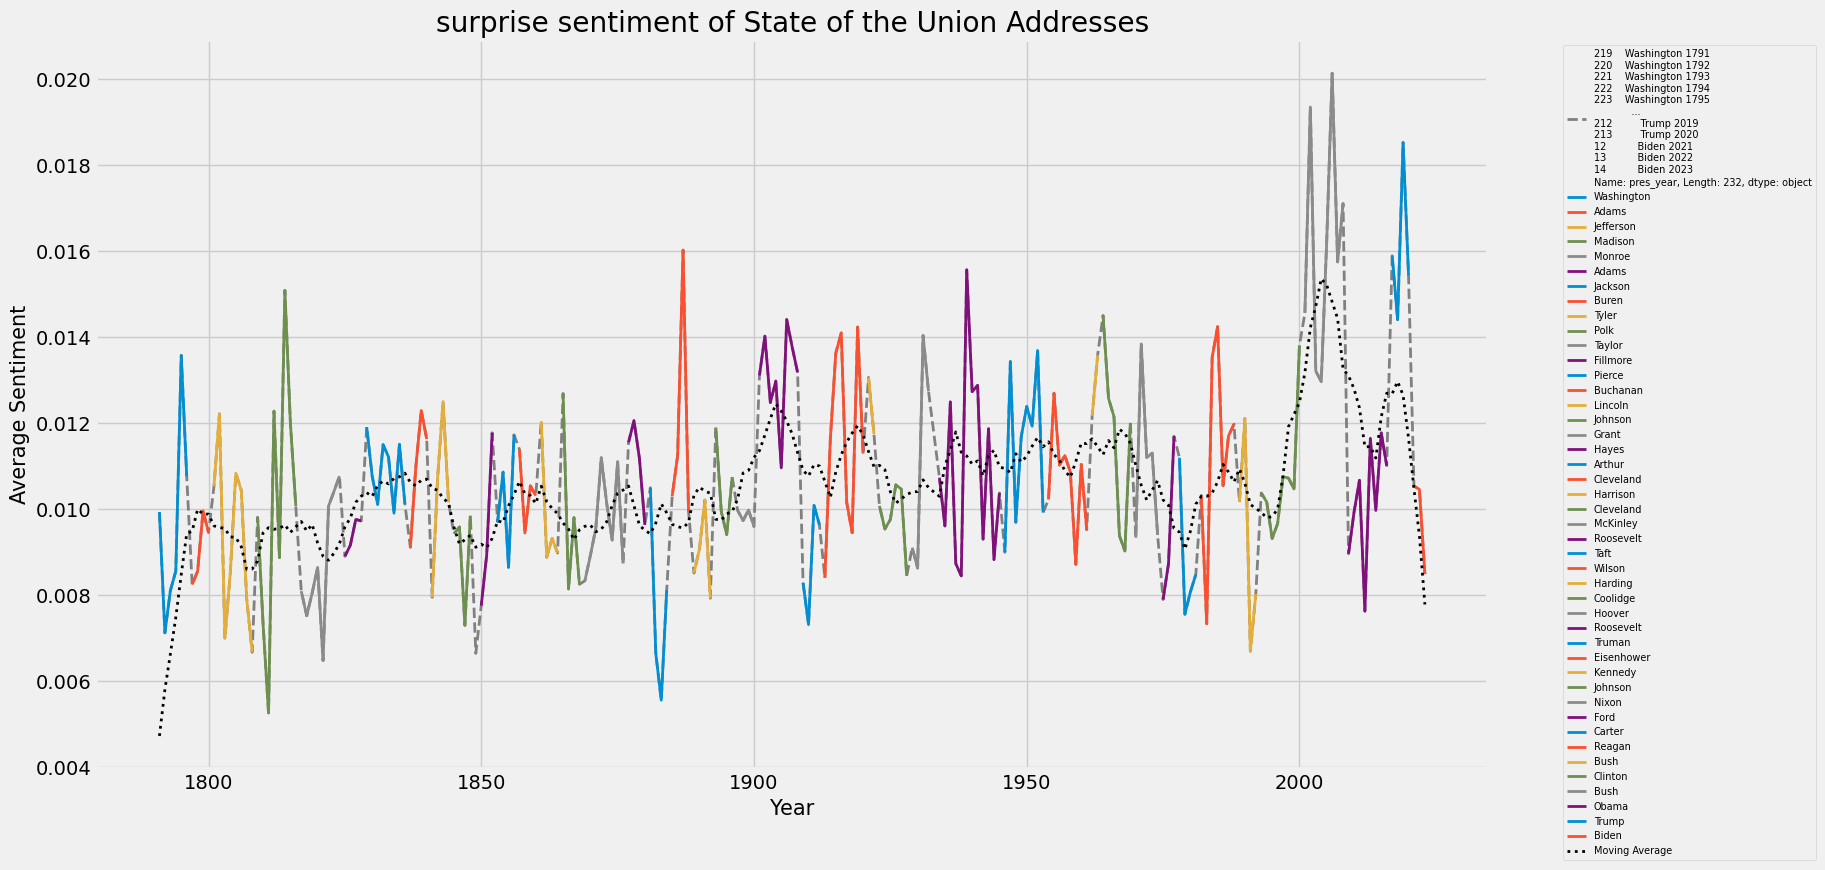

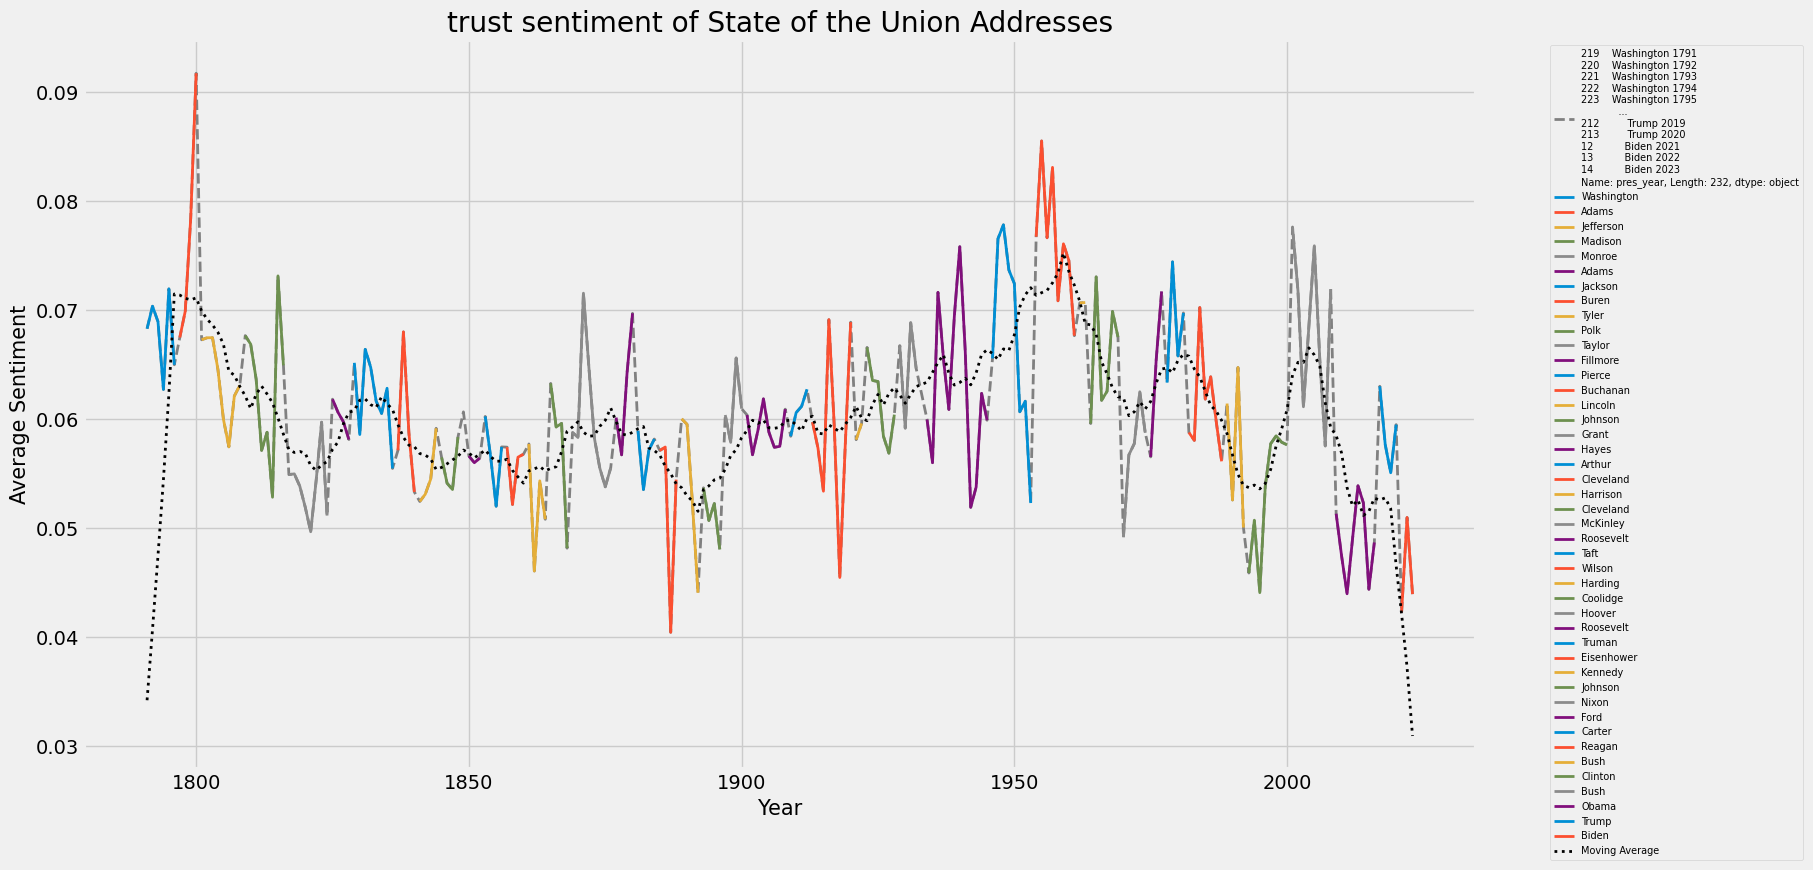

In [133]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = sotusub['year'].tolist()
for emotion in emotions:
    fig,ax = plt.subplots()
    y = sotusub[emotion]
    ctr=0
    plt.plot(x,y,label = sotusub['pres_year'],linestyle = 'dashed',linewidth=2, color = 'gray')
    for presyrs in presyears:
        plt.plot(presyrs, y[ctr:ctr+len(presyrs)],label = sotusub.iloc[ctr]['pres'],linewidth=2)
        ctr+=len(presyrs)
    plt.plot(x,movingaverage(y, 10), color='k', linewidth=2, linestyle=':', label = 'Moving Average')
    plt.title('{} sentiment of State of the Union Addresses'.format(emotion, fontsize=24))
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.legend(loc='best', fontsize=7, bbox_to_anchor=(1.05, 1))
    image_format = "png"
    image_name = "sotu_%s_sentiment.%s"%(emotion,image_format)
    fig.savefig(image_name, format=image_format, dpi = 300)
    plt.show()

<div class="alert alert-info" role="alert" style='color:blue'><h3>Exercise for Part IV</h3>

<p>26. Copying some of the relevant code from above, create a single plot charting the emotion "sadness" across the corpus. Experiment with the line thickness and color.</p>
</div>

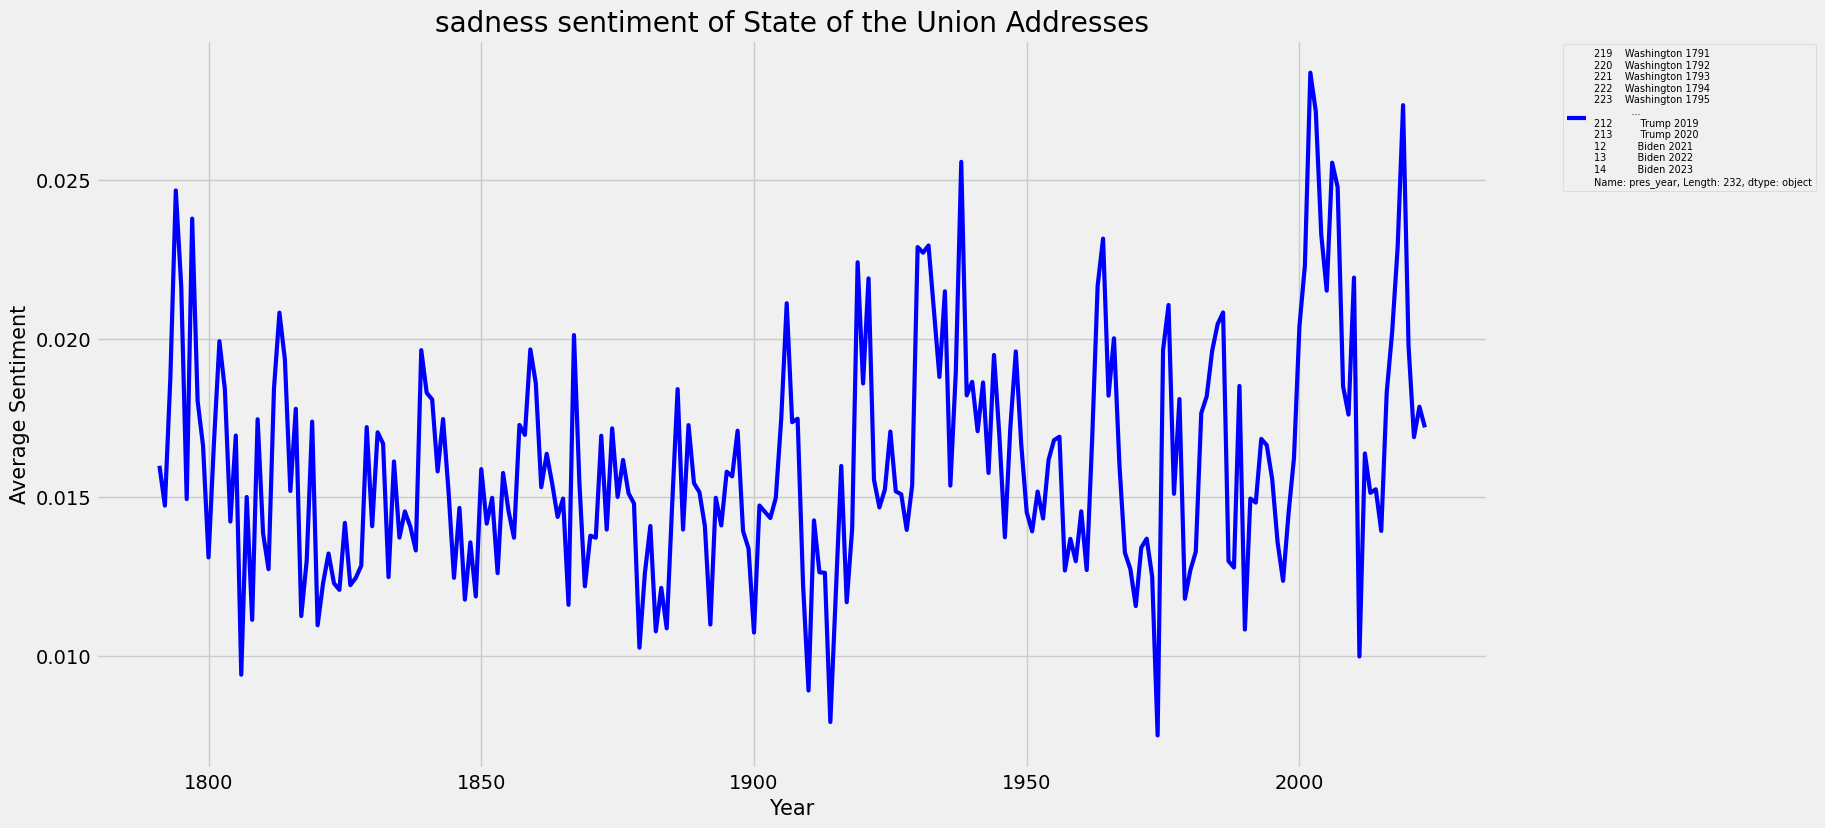

In [134]:
x = sotusub['year'].tolist()
y = sotusub['sadness']
plt.plot(x,y,label = sotusub['pres_year'],linewidth=3, color = 'blue')
plt.title('{} sentiment of State of the Union Addresses'.format('sadness', fontsize=24))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.legend(loc='best', fontsize=7, bbox_to_anchor=(1.05, 1))
image_format = "png"